In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 98% !important }<style>"))

# Analysis

In [27]:
from utilities import *
from models import *

from sklearn.preprocessing import LabelEncoder
import joblib

In [3]:
pin_file = "../Data/pin.csv"

pin = read_pin(pin_file)

In [4]:
filename = "../Data/rssi4.csv"
B1 = "0117C55D14E4"

data = read_data(filename, B1)

All beacons: ['0117C55D14E4']
Selecting 0117C55D14E4


In [5]:
data[scanners] = minMaxScaling(data[scanners])

In [6]:
data_grouped = data.groupby(["location", pd.Grouper(key="time", freq="1s")]).mean().reset_index()

## Train Validation Test Split

In [7]:
train, validation, test = train_validation_test_split(data_grouped)

In [8]:
train.groupby("location")[scanners].count()

,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
location,,,,,,,,,,,,,,,,,
V1_11,37,46,38,48,49,47,41,49,45,31,38,52,51,19,18,19,43
V1_12,53,43,36,56,53,52,35,37,64,38,43,65,64,41,53,40,44
V1_13,39,55,37,50,31,44,48,48,67,11,31,50,48,50,51,13,41
V1_14,27,64,34,42,37,49,62,39,65,9,64,32,49,40,52,41,46
V1_20,61,58,56,53,56,53,45,44,47,25,40,51,67,11,38,19,41
V1_21,44,57,39,48,54,48,58,39,63,18,48,49,43,41,41,37,39
V1_22,45,45,38,46,41,64,67,24,64,24,66,43,36,7,53,51,32
V1_23,40,47,42,37,26,73,63,34,76,23,64,43,48,7,59,55,31
V1_24,16,37,39,34,30,47,47,31,64,15,56,33,42,16,36,51,17


In [9]:
validation.shape

(344, 19)

In [10]:
test.shape

(344, 19)

In [11]:
train.sort_values("time", inplace=True)
validation.sort_values("time", inplace=True)
test.sort_values("time", inplace=True)

## Imputation
1. Forward fill
2. Fill NaN

In [12]:
train_imputed = train.set_index("location").groupby("location").ffill()
train_imputed.fillna(0, inplace=True)
train_imputed.reset_index(inplace=True)

In [13]:
validation_imputed = validation.set_index("location").groupby("location").ffill()
validation_imputed.fillna(0, inplace=True)
validation_imputed.reset_index(inplace=True)

In [14]:
test_imputed = test.set_index("location").groupby("location").ffill()
test_imputed.fillna(0, inplace=True)
test_imputed.reset_index(inplace=True)

## Create Label Encoding for Each Fingerprint Location

In [15]:
X_train, y_train = train_imputed[scanners].values, train_imputed["location"].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed["location"].values
X_test, y_test = test_imputed[scanners].values, test_imputed["location"].values

In [16]:
enc = LabelEncoder()

y_train = enc.fit_transform(y_train)
y_validation = enc.transform(y_validation)
y_test = enc.transform(y_test)

In [17]:
y_train.shape

(1030,)

In [28]:
joblib.dump(enc, "../Models/MLP_Classification_GroupBy_FFill_MinMax_Encoder.joblib")

['../Models/MLP_Classification_GroupBy_FFill_MinMax_Encoder.joblib']

## Model Training

In [18]:
model = MLPClassifier(size='small')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1152      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                910       
Total params: 2,062
Trainable params: 2,062
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, X_validation, y_validation)

Train on 1030 samples, validate on 344 samples
Epoch 1/2000
1030/1030 [==============================] - 1s 601us/sample - loss: 2.6631 - accuracy: 0.0845 - val_loss: 2.6036 - val_accuracy: 0.1250
Epoch 2/2000
1030/1030 [==============================] - 0s 51us/sample - loss: 2.5955 - accuracy: 0.1117 - val_loss: 2.5384 - val_accuracy: 0.2151
Epoch 3/2000
1030/1030 [==============================] - 0s 54us/sample - loss: 2.5220 - accuracy: 0.1563 - val_loss: 2.4686 - val_accuracy: 0.2442
Epoch 4/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 2.4535 - accuracy: 0.2107 - val_loss: 2.3974 - val_accuracy: 0.3169
Epoch 5/2000
1030/1030 [==============================] - 0s 58us/sample - loss: 2.3705 - accuracy: 0.2583 - val_loss: 2.3179 - val_accuracy: 0.4535
Epoch 6/2000
1030/1030 [==============================] - 0s 78us/sample - loss: 2.2974 - accuracy: 0.2767 - val_loss: 2.2397 - val_accuracy: 0.5843
Epoch 7/2000
1030/1030 [==============================] - 

1030/1030 [==============================] - 0s 41us/sample - loss: 0.7932 - accuracy: 0.7942 - val_loss: 0.6419 - val_accuracy: 0.9273
Epoch 56/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.7794 - accuracy: 0.8117 - val_loss: 0.6256 - val_accuracy: 0.9244
Epoch 57/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.7546 - accuracy: 0.8039 - val_loss: 0.6185 - val_accuracy: 0.9360
Epoch 58/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.7538 - accuracy: 0.8155 - val_loss: 0.6119 - val_accuracy: 0.9302
Epoch 59/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.7530 - accuracy: 0.8146 - val_loss: 0.6029 - val_accuracy: 0.9244
Epoch 60/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.7318 - accuracy: 0.8146 - val_loss: 0.5951 - val_accuracy: 0.9273
Epoch 61/2000
1030/1030 [==============================] - 0s 39us/sample - loss: 0.7159 - accuracy: 0.8340 - val_

1030/1030 [==============================] - 0s 43us/sample - loss: 0.4660 - accuracy: 0.8854 - val_loss: 0.4026 - val_accuracy: 0.9331
Epoch 110/2000
1030/1030 [==============================] - 0s 53us/sample - loss: 0.4714 - accuracy: 0.8893 - val_loss: 0.3981 - val_accuracy: 0.9331
Epoch 111/2000
1030/1030 [==============================] - 0s 59us/sample - loss: 0.4668 - accuracy: 0.9039 - val_loss: 0.3964 - val_accuracy: 0.9448
Epoch 112/2000
1030/1030 [==============================] - 0s 54us/sample - loss: 0.4700 - accuracy: 0.8903 - val_loss: 0.3965 - val_accuracy: 0.9273
Epoch 113/2000
1030/1030 [==============================] - 0s 48us/sample - loss: 0.4581 - accuracy: 0.8932 - val_loss: 0.3940 - val_accuracy: 0.9331
Epoch 114/2000
1030/1030 [==============================] - 0s 52us/sample - loss: 0.4500 - accuracy: 0.9029 - val_loss: 0.3957 - val_accuracy: 0.9448
Epoch 115/2000
1030/1030 [==============================] - 0s 54us/sample - loss: 0.4685 - accuracy: 0.8903 

1030/1030 [==============================] - 0s 62us/sample - loss: 0.3685 - accuracy: 0.9107 - val_loss: 0.3446 - val_accuracy: 0.9448
Epoch 164/2000
1030/1030 [==============================] - 0s 58us/sample - loss: 0.3646 - accuracy: 0.9184 - val_loss: 0.3412 - val_accuracy: 0.9477
Epoch 165/2000
1030/1030 [==============================] - 0s 52us/sample - loss: 0.3801 - accuracy: 0.9204 - val_loss: 0.3416 - val_accuracy: 0.9506
Epoch 166/2000
1030/1030 [==============================] - 0s 52us/sample - loss: 0.3699 - accuracy: 0.9252 - val_loss: 0.3401 - val_accuracy: 0.9419
Epoch 167/2000
1030/1030 [==============================] - 0s 42us/sample - loss: 0.3512 - accuracy: 0.9175 - val_loss: 0.3395 - val_accuracy: 0.9477
Epoch 168/2000
1030/1030 [==============================] - 0s 42us/sample - loss: 0.3533 - accuracy: 0.9252 - val_loss: 0.3389 - val_accuracy: 0.9477
Epoch 169/2000
1030/1030 [==============================] - 0s 39us/sample - loss: 0.3427 - accuracy: 0.9340 

1030/1030 [==============================] - 0s 51us/sample - loss: 0.3340 - accuracy: 0.9369 - val_loss: 0.3198 - val_accuracy: 0.9506
Epoch 218/2000
1030/1030 [==============================] - 0s 57us/sample - loss: 0.2875 - accuracy: 0.9485 - val_loss: 0.3179 - val_accuracy: 0.9535
Epoch 219/2000
1030/1030 [==============================] - 0s 55us/sample - loss: 0.3085 - accuracy: 0.9408 - val_loss: 0.3206 - val_accuracy: 0.9506
Epoch 220/2000
1030/1030 [==============================] - 0s 53us/sample - loss: 0.2967 - accuracy: 0.9379 - val_loss: 0.3193 - val_accuracy: 0.9564
Epoch 221/2000
1030/1030 [==============================] - 0s 52us/sample - loss: 0.2887 - accuracy: 0.9505 - val_loss: 0.3188 - val_accuracy: 0.9477
Epoch 222/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.3056 - accuracy: 0.9340 - val_loss: 0.3178 - val_accuracy: 0.9477
Epoch 223/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.2994 - accuracy: 0.9417 

1030/1030 [==============================] - 0s 41us/sample - loss: 0.2717 - accuracy: 0.9447 - val_loss: 0.3116 - val_accuracy: 0.9419
Epoch 272/2000
1030/1030 [==============================] - 0s 46us/sample - loss: 0.2714 - accuracy: 0.9573 - val_loss: 0.3091 - val_accuracy: 0.9535
Epoch 273/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.2635 - accuracy: 0.9476 - val_loss: 0.3080 - val_accuracy: 0.9535
Epoch 274/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.2686 - accuracy: 0.9485 - val_loss: 0.3152 - val_accuracy: 0.9448
Epoch 275/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.2623 - accuracy: 0.9505 - val_loss: 0.3075 - val_accuracy: 0.9535
Epoch 276/2000
1030/1030 [==============================] - 0s 39us/sample - loss: 0.2560 - accuracy: 0.9515 - val_loss: 0.3036 - val_accuracy: 0.9506
Epoch 277/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.2486 - accuracy: 0.9583 

1030/1030 [==============================] - 0s 43us/sample - loss: 0.2392 - accuracy: 0.9544 - val_loss: 0.2975 - val_accuracy: 0.9535
Epoch 326/2000
1030/1030 [==============================] - 0s 57us/sample - loss: 0.2492 - accuracy: 0.9495 - val_loss: 0.2965 - val_accuracy: 0.9477
Epoch 327/2000
1030/1030 [==============================] - 0s 55us/sample - loss: 0.2373 - accuracy: 0.9544 - val_loss: 0.2997 - val_accuracy: 0.9535
Epoch 328/2000
1030/1030 [==============================] - 0s 50us/sample - loss: 0.2156 - accuracy: 0.9631 - val_loss: 0.3022 - val_accuracy: 0.9506
Epoch 329/2000
1030/1030 [==============================] - 0s 49us/sample - loss: 0.2339 - accuracy: 0.9524 - val_loss: 0.3013 - val_accuracy: 0.9506
Epoch 330/2000
1030/1030 [==============================] - 0s 47us/sample - loss: 0.2439 - accuracy: 0.9621 - val_loss: 0.2993 - val_accuracy: 0.9593
Epoch 331/2000
1030/1030 [==============================] - 0s 48us/sample - loss: 0.2447 - accuracy: 0.9476 

1030/1030 [==============================] - 0s 34us/sample - loss: 0.2214 - accuracy: 0.9621 - val_loss: 0.2927 - val_accuracy: 0.9535
Epoch 380/2000
1030/1030 [==============================] - 0s 35us/sample - loss: 0.2215 - accuracy: 0.9583 - val_loss: 0.2954 - val_accuracy: 0.9477
Epoch 381/2000
1030/1030 [==============================] - 0s 35us/sample - loss: 0.2111 - accuracy: 0.9670 - val_loss: 0.2902 - val_accuracy: 0.9593
Epoch 382/2000
1030/1030 [==============================] - 0s 35us/sample - loss: 0.2320 - accuracy: 0.9553 - val_loss: 0.2928 - val_accuracy: 0.9535
Epoch 383/2000
1030/1030 [==============================] - 0s 35us/sample - loss: 0.2141 - accuracy: 0.9602 - val_loss: 0.2962 - val_accuracy: 0.9535
Epoch 384/2000
1030/1030 [==============================] - 0s 35us/sample - loss: 0.2240 - accuracy: 0.9466 - val_loss: 0.2990 - val_accuracy: 0.9535
Epoch 385/2000
1030/1030 [==============================] - 0s 35us/sample - loss: 0.2081 - accuracy: 0.9583 

1030/1030 [==============================] - 0s 35us/sample - loss: 0.2089 - accuracy: 0.9544 - val_loss: 0.2947 - val_accuracy: 0.9535
Epoch 434/2000
1030/1030 [==============================] - 0s 36us/sample - loss: 0.2130 - accuracy: 0.9553 - val_loss: 0.2953 - val_accuracy: 0.9564
Epoch 435/2000
1030/1030 [==============================] - 0s 35us/sample - loss: 0.2106 - accuracy: 0.9660 - val_loss: 0.2969 - val_accuracy: 0.9448
Epoch 436/2000
1030/1030 [==============================] - 0s 35us/sample - loss: 0.2040 - accuracy: 0.9680 - val_loss: 0.2954 - val_accuracy: 0.9564
Epoch 437/2000
1030/1030 [==============================] - 0s 34us/sample - loss: 0.2085 - accuracy: 0.9553 - val_loss: 0.3028 - val_accuracy: 0.9448
Epoch 438/2000
1030/1030 [==============================] - 0s 34us/sample - loss: 0.2203 - accuracy: 0.9573 - val_loss: 0.2926 - val_accuracy: 0.9535
Epoch 439/2000
1030/1030 [==============================] - 0s 35us/sample - loss: 0.2093 - accuracy: 0.9621 

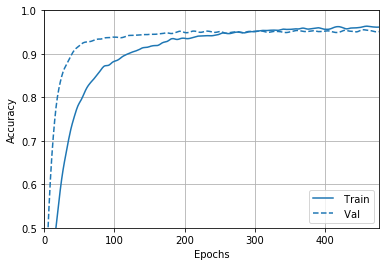

In [20]:
model.show_history()

## Model Validation

In [21]:
model.model_validation(X_validation, y_validation)

344/1 - 0s - loss: 0.1883 - accuracy: 0.9535
Validation loss: 0.29685728737088135
Accuracy: 0.95348835


## Model Testing

In [22]:
model.model_testing(X_test, y_test)

344/1 - 0s - loss: 0.2907 - accuracy: 0.9331
Test loss: 0.25540522433990653
Accuracy 0.93313956


## Plotting Learning Curves

In [23]:
train_loss = []
val_loss = []

for f in range(1, 11, 1):
    frac = f / 10.0
    sample = data_grouped.sample(frac=frac, random_state=12345)
    sample_grouped = sample.groupby(["location", pd.Grouper(key="time", freq="1s")]).mean().reset_index()
    train, validation, test = train_validation_test_split(sample_grouped)

    train.sort_values("time", inplace=True)
    validation.sort_values("time", inplace=True)
    test.sort_values("time", inplace=True)

    train_imputed = train.set_index("location").groupby("location").ffill()
    train_imputed.fillna(0, inplace=True)
    train_imputed.reset_index(inplace=True)

    validation_imputed = validation.set_index("location").groupby("location").ffill()
    validation_imputed.fillna(0, inplace=True)
    validation_imputed.reset_index(inplace=True)

    test_imputed = test.set_index("location").groupby("location").ffill()
    test_imputed.fillna(0, inplace=True)
    test_imputed.reset_index(inplace=True)

    X_train, y_train = train_imputed[scanners].values, train_imputed["location"].values
    X_validation, y_validation = validation_imputed[scanners].values, validation_imputed["location"].values
    X_test, y_test = test_imputed[scanners].values, test_imputed["location"].values

    enc = LabelEncoder()

    y_train = enc.fit_transform(y_train)
    y_validation = enc.transform(y_validation)
    y_test = enc.transform(y_test)

    model = MLPClassifier(size='small')
    history = model.fit(X_train, y_train, X_validation, y_validation)

    train_loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                1152      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                910       
Total params: 2,062
Trainable params: 2,062
Non-trainable params: 0
_________________________________________________________________
Train on 103 samples, validate on 34 samples
Epoch 1/2000
103/103 [==============================] - 0s 3ms/sample - loss: 2.7873 - accuracy: 0.0485 - val_loss: 2.6986 - val_accuracy: 0.0294
Epoch 2/2000
103/103 [==============================] - 0s 132us/sample - loss: 2.6722 - accuracy: 0.0971 - val_loss: 2.6789 - val_accuracy: 0.0294
Epoch 3/2000
103/103 [=====================

Epoch 51/2000
103/103 [==============================] - 0s 130us/sample - loss: 2.1717 - accuracy: 0.2913 - val_loss: 2.2491 - val_accuracy: 0.1471
Epoch 52/2000
103/103 [==============================] - 0s 129us/sample - loss: 2.1808 - accuracy: 0.3301 - val_loss: 2.2417 - val_accuracy: 0.1471
Epoch 53/2000
103/103 [==============================] - 0s 121us/sample - loss: 2.1261 - accuracy: 0.3592 - val_loss: 2.2340 - val_accuracy: 0.1471
Epoch 54/2000
103/103 [==============================] - 0s 124us/sample - loss: 2.1080 - accuracy: 0.2913 - val_loss: 2.2242 - val_accuracy: 0.1471
Epoch 55/2000
103/103 [==============================] - 0s 110us/sample - loss: 2.1922 - accuracy: 0.2330 - val_loss: 2.2215 - val_accuracy: 0.1471
Epoch 56/2000
103/103 [==============================] - 0s 109us/sample - loss: 2.1547 - accuracy: 0.3204 - val_loss: 2.2158 - val_accuracy: 0.1765
Epoch 57/2000
103/103 [==============================] - 0s 110us/sample - loss: 2.1172 - accuracy: 0.3301

Epoch 106/2000
103/103 [==============================] - 0s 106us/sample - loss: 1.7010 - accuracy: 0.4951 - val_loss: 1.8894 - val_accuracy: 0.2941
Epoch 107/2000
103/103 [==============================] - 0s 110us/sample - loss: 1.7592 - accuracy: 0.3883 - val_loss: 1.8802 - val_accuracy: 0.2647
Epoch 108/2000
103/103 [==============================] - 0s 110us/sample - loss: 1.7587 - accuracy: 0.4660 - val_loss: 1.8782 - val_accuracy: 0.2941
Epoch 109/2000
103/103 [==============================] - 0s 115us/sample - loss: 1.6548 - accuracy: 0.5340 - val_loss: 1.8801 - val_accuracy: 0.2941
Epoch 110/2000
103/103 [==============================] - 0s 104us/sample - loss: 1.7066 - accuracy: 0.5049 - val_loss: 1.8754 - val_accuracy: 0.2941
Epoch 111/2000
103/103 [==============================] - 0s 112us/sample - loss: 1.6926 - accuracy: 0.4175 - val_loss: 1.8602 - val_accuracy: 0.2941
Epoch 112/2000
103/103 [==============================] - 0s 108us/sample - loss: 1.7026 - accuracy:

103/103 [==============================] - 0s 107us/sample - loss: 1.3877 - accuracy: 0.6019 - val_loss: 1.6592 - val_accuracy: 0.3529
Epoch 161/2000
103/103 [==============================] - 0s 109us/sample - loss: 1.3834 - accuracy: 0.6602 - val_loss: 1.6531 - val_accuracy: 0.4118
Epoch 162/2000
103/103 [==============================] - 0s 111us/sample - loss: 1.4158 - accuracy: 0.6117 - val_loss: 1.6413 - val_accuracy: 0.4118
Epoch 163/2000
103/103 [==============================] - 0s 112us/sample - loss: 1.5008 - accuracy: 0.5243 - val_loss: 1.6343 - val_accuracy: 0.4118
Epoch 164/2000
103/103 [==============================] - 0s 111us/sample - loss: 1.4037 - accuracy: 0.5728 - val_loss: 1.6301 - val_accuracy: 0.4118
Epoch 165/2000
103/103 [==============================] - 0s 113us/sample - loss: 1.3631 - accuracy: 0.6214 - val_loss: 1.6287 - val_accuracy: 0.4412
Epoch 166/2000
103/103 [==============================] - 0s 107us/sample - loss: 1.3883 - accuracy: 0.5728 - val_l

Epoch 215/2000
103/103 [==============================] - 0s 110us/sample - loss: 1.2112 - accuracy: 0.6019 - val_loss: 1.4721 - val_accuracy: 0.5000
Epoch 216/2000
103/103 [==============================] - 0s 116us/sample - loss: 1.1563 - accuracy: 0.7573 - val_loss: 1.4683 - val_accuracy: 0.5000
Epoch 217/2000
103/103 [==============================] - 0s 111us/sample - loss: 1.2063 - accuracy: 0.6796 - val_loss: 1.4701 - val_accuracy: 0.5588
Epoch 218/2000
103/103 [==============================] - 0s 112us/sample - loss: 1.0533 - accuracy: 0.7670 - val_loss: 1.4669 - val_accuracy: 0.5294
Epoch 219/2000
103/103 [==============================] - 0s 110us/sample - loss: 1.0843 - accuracy: 0.8058 - val_loss: 1.4645 - val_accuracy: 0.5000
Epoch 220/2000
103/103 [==============================] - 0s 109us/sample - loss: 1.1655 - accuracy: 0.6796 - val_loss: 1.4659 - val_accuracy: 0.5294
Epoch 221/2000
103/103 [==============================] - 0s 115us/sample - loss: 1.0836 - accuracy:

103/103 [==============================] - 0s 141us/sample - loss: 1.0269 - accuracy: 0.7087 - val_loss: 1.3238 - val_accuracy: 0.5882
Epoch 270/2000
103/103 [==============================] - 0s 143us/sample - loss: 0.9760 - accuracy: 0.7184 - val_loss: 1.3199 - val_accuracy: 0.6471
Epoch 271/2000
103/103 [==============================] - 0s 130us/sample - loss: 0.9485 - accuracy: 0.7184 - val_loss: 1.3230 - val_accuracy: 0.5882
Epoch 272/2000
103/103 [==============================] - 0s 138us/sample - loss: 0.9351 - accuracy: 0.7087 - val_loss: 1.3286 - val_accuracy: 0.5882
Epoch 273/2000
103/103 [==============================] - 0s 135us/sample - loss: 0.9329 - accuracy: 0.7573 - val_loss: 1.3348 - val_accuracy: 0.5882
Epoch 274/2000
103/103 [==============================] - 0s 144us/sample - loss: 0.9655 - accuracy: 0.8155 - val_loss: 1.3351 - val_accuracy: 0.5882
Epoch 275/2000
103/103 [==============================] - 0s 150us/sample - loss: 0.8931 - accuracy: 0.8155 - val_l

Epoch 324/2000
103/103 [==============================] - 0s 109us/sample - loss: 0.8689 - accuracy: 0.7864 - val_loss: 1.2305 - val_accuracy: 0.6176
Epoch 325/2000
103/103 [==============================] - 0s 110us/sample - loss: 0.7981 - accuracy: 0.7767 - val_loss: 1.2250 - val_accuracy: 0.5882
Epoch 326/2000
103/103 [==============================] - 0s 115us/sample - loss: 0.8509 - accuracy: 0.7670 - val_loss: 1.2214 - val_accuracy: 0.5882
Epoch 327/2000
103/103 [==============================] - 0s 104us/sample - loss: 0.7905 - accuracy: 0.8544 - val_loss: 1.2292 - val_accuracy: 0.6176
Epoch 328/2000
103/103 [==============================] - 0s 108us/sample - loss: 0.8065 - accuracy: 0.8447 - val_loss: 1.2307 - val_accuracy: 0.6176
Epoch 329/2000
103/103 [==============================] - 0s 110us/sample - loss: 0.7623 - accuracy: 0.8544 - val_loss: 1.2316 - val_accuracy: 0.6176
Epoch 330/2000
103/103 [==============================] - 0s 106us/sample - loss: 0.8734 - accuracy:

103/103 [==============================] - 0s 109us/sample - loss: 0.6789 - accuracy: 0.8641 - val_loss: 1.1577 - val_accuracy: 0.5882
Epoch 379/2000
103/103 [==============================] - 0s 111us/sample - loss: 0.6275 - accuracy: 0.9029 - val_loss: 1.1488 - val_accuracy: 0.6176
Epoch 380/2000
103/103 [==============================] - 0s 112us/sample - loss: 0.6943 - accuracy: 0.8252 - val_loss: 1.1499 - val_accuracy: 0.6176
Epoch 381/2000
103/103 [==============================] - 0s 110us/sample - loss: 0.6637 - accuracy: 0.8738 - val_loss: 1.1545 - val_accuracy: 0.6176
Epoch 382/2000
103/103 [==============================] - 0s 110us/sample - loss: 0.6979 - accuracy: 0.8350 - val_loss: 1.1567 - val_accuracy: 0.6176
Epoch 383/2000
103/103 [==============================] - 0s 114us/sample - loss: 0.7389 - accuracy: 0.8350 - val_loss: 1.1475 - val_accuracy: 0.5882
Epoch 384/2000
103/103 [==============================] - 0s 115us/sample - loss: 0.6397 - accuracy: 0.8641 - val_l

Epoch 433/2000
103/103 [==============================] - 0s 141us/sample - loss: 0.6003 - accuracy: 0.8835 - val_loss: 1.1156 - val_accuracy: 0.6176
Epoch 434/2000
103/103 [==============================] - 0s 163us/sample - loss: 0.6213 - accuracy: 0.8738 - val_loss: 1.1009 - val_accuracy: 0.6176
Epoch 435/2000
103/103 [==============================] - 0s 148us/sample - loss: 0.5774 - accuracy: 0.9029 - val_loss: 1.0979 - val_accuracy: 0.6471
Epoch 436/2000
103/103 [==============================] - 0s 152us/sample - loss: 0.5557 - accuracy: 0.9126 - val_loss: 1.1081 - val_accuracy: 0.6176
Epoch 437/2000
103/103 [==============================] - 0s 146us/sample - loss: 0.5809 - accuracy: 0.8835 - val_loss: 1.0969 - val_accuracy: 0.6471
Epoch 438/2000
103/103 [==============================] - 0s 143us/sample - loss: 0.5310 - accuracy: 0.9223 - val_loss: 1.0965 - val_accuracy: 0.6471
Epoch 439/2000
103/103 [==============================] - 0s 133us/sample - loss: 0.5982 - accuracy:

103/103 [==============================] - 0s 111us/sample - loss: 0.5386 - accuracy: 0.9029 - val_loss: 1.0777 - val_accuracy: 0.5882
Epoch 488/2000
103/103 [==============================] - 0s 114us/sample - loss: 0.5290 - accuracy: 0.9223 - val_loss: 1.0751 - val_accuracy: 0.6176
Epoch 489/2000
103/103 [==============================] - 0s 111us/sample - loss: 0.5280 - accuracy: 0.9029 - val_loss: 1.0685 - val_accuracy: 0.6176
Epoch 490/2000
103/103 [==============================] - 0s 112us/sample - loss: 0.4754 - accuracy: 0.9029 - val_loss: 1.0753 - val_accuracy: 0.6176
Epoch 491/2000
103/103 [==============================] - 0s 114us/sample - loss: 0.4989 - accuracy: 0.9126 - val_loss: 1.0773 - val_accuracy: 0.6471
Epoch 492/2000
103/103 [==============================] - 0s 108us/sample - loss: 0.5285 - accuracy: 0.9126 - val_loss: 1.0772 - val_accuracy: 0.6176
Epoch 493/2000
103/103 [==============================] - 0s 108us/sample - loss: 0.4674 - accuracy: 0.9320 - val_l

206/206 [==============================] - 0s 66us/sample - loss: 2.5288 - accuracy: 0.2330 - val_loss: 2.5175 - val_accuracy: 0.3188
Epoch 9/2000
206/206 [==============================] - 0s 87us/sample - loss: 2.5287 - accuracy: 0.1942 - val_loss: 2.5049 - val_accuracy: 0.3043
Epoch 10/2000
206/206 [==============================] - 0s 86us/sample - loss: 2.4816 - accuracy: 0.2476 - val_loss: 2.4897 - val_accuracy: 0.3333
Epoch 11/2000
206/206 [==============================] - 0s 85us/sample - loss: 2.4812 - accuracy: 0.2864 - val_loss: 2.4770 - val_accuracy: 0.3768
Epoch 12/2000
206/206 [==============================] - 0s 87us/sample - loss: 2.4943 - accuracy: 0.2670 - val_loss: 2.4631 - val_accuracy: 0.3333
Epoch 13/2000
206/206 [==============================] - 0s 81us/sample - loss: 2.4506 - accuracy: 0.3155 - val_loss: 2.4493 - val_accuracy: 0.3623
Epoch 14/2000
206/206 [==============================] - 0s 78us/sample - loss: 2.4219 - accuracy: 0.3204 - val_loss: 2.4351 - 

206/206 [==============================] - 0s 67us/sample - loss: 1.6679 - accuracy: 0.4660 - val_loss: 1.7331 - val_accuracy: 0.6087
Epoch 64/2000
206/206 [==============================] - 0s 67us/sample - loss: 1.6752 - accuracy: 0.5291 - val_loss: 1.7170 - val_accuracy: 0.6377
Epoch 65/2000
206/206 [==============================] - 0s 68us/sample - loss: 1.6454 - accuracy: 0.5194 - val_loss: 1.7050 - val_accuracy: 0.6522
Epoch 66/2000
206/206 [==============================] - 0s 66us/sample - loss: 1.6664 - accuracy: 0.5631 - val_loss: 1.6955 - val_accuracy: 0.6232
Epoch 67/2000
206/206 [==============================] - 0s 68us/sample - loss: 1.6350 - accuracy: 0.5485 - val_loss: 1.6859 - val_accuracy: 0.6377
Epoch 68/2000
206/206 [==============================] - 0s 68us/sample - loss: 1.6281 - accuracy: 0.5291 - val_loss: 1.6768 - val_accuracy: 0.6232
Epoch 69/2000
206/206 [==============================] - 0s 66us/sample - loss: 1.6483 - accuracy: 0.5049 - val_loss: 1.6663 -

206/206 [==============================] - 0s 70us/sample - loss: 1.1557 - accuracy: 0.6893 - val_loss: 1.2691 - val_accuracy: 0.7681
Epoch 119/2000
206/206 [==============================] - 0s 68us/sample - loss: 1.1673 - accuracy: 0.6796 - val_loss: 1.2643 - val_accuracy: 0.7391
Epoch 120/2000
206/206 [==============================] - 0s 68us/sample - loss: 1.1548 - accuracy: 0.7524 - val_loss: 1.2539 - val_accuracy: 0.7391
Epoch 121/2000
206/206 [==============================] - 0s 67us/sample - loss: 1.1049 - accuracy: 0.7087 - val_loss: 1.2498 - val_accuracy: 0.7391
Epoch 122/2000
206/206 [==============================] - 0s 66us/sample - loss: 1.1257 - accuracy: 0.7184 - val_loss: 1.2468 - val_accuracy: 0.7391
Epoch 123/2000
206/206 [==============================] - 0s 68us/sample - loss: 1.1554 - accuracy: 0.6942 - val_loss: 1.2335 - val_accuracy: 0.7681
Epoch 124/2000
206/206 [==============================] - 0s 68us/sample - loss: 1.1487 - accuracy: 0.6942 - val_loss: 1.

206/206 [==============================] - 0s 67us/sample - loss: 0.8410 - accuracy: 0.7913 - val_loss: 0.9949 - val_accuracy: 0.7826
Epoch 174/2000
206/206 [==============================] - 0s 68us/sample - loss: 0.8331 - accuracy: 0.8010 - val_loss: 0.9892 - val_accuracy: 0.7826
Epoch 175/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.8181 - accuracy: 0.8398 - val_loss: 0.9856 - val_accuracy: 0.7826
Epoch 176/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.8154 - accuracy: 0.8252 - val_loss: 0.9818 - val_accuracy: 0.7681
Epoch 177/2000
206/206 [==============================] - 0s 66us/sample - loss: 0.8364 - accuracy: 0.8447 - val_loss: 0.9737 - val_accuracy: 0.7826
Epoch 178/2000
206/206 [==============================] - 0s 68us/sample - loss: 0.7984 - accuracy: 0.8398 - val_loss: 0.9705 - val_accuracy: 0.7681
Epoch 179/2000
206/206 [==============================] - 0s 65us/sample - loss: 0.8480 - accuracy: 0.7913 - val_loss: 0.

206/206 [==============================] - 0s 67us/sample - loss: 0.6815 - accuracy: 0.8883 - val_loss: 0.8396 - val_accuracy: 0.7681
Epoch 229/2000
206/206 [==============================] - 0s 78us/sample - loss: 0.6298 - accuracy: 0.8738 - val_loss: 0.8369 - val_accuracy: 0.7826
Epoch 230/2000
206/206 [==============================] - 0s 113us/sample - loss: 0.6370 - accuracy: 0.8932 - val_loss: 0.8367 - val_accuracy: 0.7826
Epoch 231/2000
206/206 [==============================] - 0s 82us/sample - loss: 0.6417 - accuracy: 0.8641 - val_loss: 0.8315 - val_accuracy: 0.7971
Epoch 232/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.6274 - accuracy: 0.8447 - val_loss: 0.8276 - val_accuracy: 0.7826
Epoch 233/2000
206/206 [==============================] - 0s 85us/sample - loss: 0.6429 - accuracy: 0.8835 - val_loss: 0.8223 - val_accuracy: 0.7826
Epoch 234/2000
206/206 [==============================] - 0s 73us/sample - loss: 0.6747 - accuracy: 0.8350 - val_loss: 0

206/206 [==============================] - 0s 68us/sample - loss: 0.5320 - accuracy: 0.8883 - val_loss: 0.7483 - val_accuracy: 0.7971
Epoch 284/2000
206/206 [==============================] - 0s 69us/sample - loss: 0.5536 - accuracy: 0.8689 - val_loss: 0.7410 - val_accuracy: 0.8116
Epoch 285/2000
206/206 [==============================] - 0s 71us/sample - loss: 0.5127 - accuracy: 0.9175 - val_loss: 0.7501 - val_accuracy: 0.7971
Epoch 286/2000
206/206 [==============================] - 0s 71us/sample - loss: 0.4962 - accuracy: 0.8932 - val_loss: 0.7470 - val_accuracy: 0.7826
Epoch 287/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.5086 - accuracy: 0.9126 - val_loss: 0.7478 - val_accuracy: 0.7971
Epoch 288/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.4770 - accuracy: 0.9175 - val_loss: 0.7459 - val_accuracy: 0.8116
Epoch 289/2000
206/206 [==============================] - 0s 70us/sample - loss: 0.5029 - accuracy: 0.8883 - val_loss: 0.

206/206 [==============================] - 0s 67us/sample - loss: 0.5021 - accuracy: 0.8835 - val_loss: 0.6942 - val_accuracy: 0.7971
Epoch 339/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.4353 - accuracy: 0.9272 - val_loss: 0.6904 - val_accuracy: 0.7826
Epoch 340/2000
206/206 [==============================] - 0s 66us/sample - loss: 0.4752 - accuracy: 0.8883 - val_loss: 0.6961 - val_accuracy: 0.7971
Epoch 341/2000
206/206 [==============================] - 0s 65us/sample - loss: 0.4046 - accuracy: 0.9369 - val_loss: 0.6974 - val_accuracy: 0.7971
Epoch 342/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.4027 - accuracy: 0.9272 - val_loss: 0.6971 - val_accuracy: 0.7971
Epoch 343/2000
206/206 [==============================] - 0s 69us/sample - loss: 0.4505 - accuracy: 0.9272 - val_loss: 0.7024 - val_accuracy: 0.8261
Epoch 344/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.4442 - accuracy: 0.9223 - val_loss: 0.

206/206 [==============================] - 0s 68us/sample - loss: 0.3781 - accuracy: 0.9417 - val_loss: 0.6632 - val_accuracy: 0.7971
Epoch 394/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.4066 - accuracy: 0.9078 - val_loss: 0.6567 - val_accuracy: 0.7971
Epoch 395/2000
206/206 [==============================] - 0s 68us/sample - loss: 0.3944 - accuracy: 0.9417 - val_loss: 0.6696 - val_accuracy: 0.7826
Epoch 396/2000
206/206 [==============================] - 0s 68us/sample - loss: 0.3743 - accuracy: 0.9175 - val_loss: 0.6665 - val_accuracy: 0.7826
Epoch 397/2000
206/206 [==============================] - 0s 66us/sample - loss: 0.4331 - accuracy: 0.9175 - val_loss: 0.6798 - val_accuracy: 0.7826
Epoch 398/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.3884 - accuracy: 0.9175 - val_loss: 0.6759 - val_accuracy: 0.7826
Epoch 399/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.3633 - accuracy: 0.9223 - val_loss: 0.

206/206 [==============================] - 0s 69us/sample - loss: 0.3543 - accuracy: 0.9320 - val_loss: 0.6554 - val_accuracy: 0.8116
Epoch 449/2000
206/206 [==============================] - 0s 68us/sample - loss: 0.3584 - accuracy: 0.9466 - val_loss: 0.6606 - val_accuracy: 0.7971
Epoch 450/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.3217 - accuracy: 0.9417 - val_loss: 0.6511 - val_accuracy: 0.8116
Epoch 451/2000
206/206 [==============================] - 0s 69us/sample - loss: 0.3663 - accuracy: 0.9417 - val_loss: 0.6530 - val_accuracy: 0.7971
Epoch 452/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.3673 - accuracy: 0.9126 - val_loss: 0.6497 - val_accuracy: 0.8116
Epoch 453/2000
206/206 [==============================] - 0s 68us/sample - loss: 0.3482 - accuracy: 0.9369 - val_loss: 0.6563 - val_accuracy: 0.8116
Epoch 454/2000
206/206 [==============================] - 0s 69us/sample - loss: 0.3462 - accuracy: 0.9320 - val_loss: 0.

206/206 [==============================] - 0s 68us/sample - loss: 0.3041 - accuracy: 0.9515 - val_loss: 0.6596 - val_accuracy: 0.7971
Epoch 504/2000
206/206 [==============================] - 0s 69us/sample - loss: 0.3346 - accuracy: 0.9369 - val_loss: 0.6567 - val_accuracy: 0.7971
Epoch 505/2000
206/206 [==============================] - 0s 68us/sample - loss: 0.3372 - accuracy: 0.9515 - val_loss: 0.6595 - val_accuracy: 0.7971
Epoch 506/2000
206/206 [==============================] - 0s 68us/sample - loss: 0.3285 - accuracy: 0.9320 - val_loss: 0.6553 - val_accuracy: 0.7971
Epoch 507/2000
206/206 [==============================] - 0s 67us/sample - loss: 0.3076 - accuracy: 0.9417 - val_loss: 0.6577 - val_accuracy: 0.8116
Epoch 508/2000
206/206 [==============================] - 0s 69us/sample - loss: 0.3044 - accuracy: 0.9563 - val_loss: 0.6644 - val_accuracy: 0.7971
Epoch 509/2000
206/206 [==============================] - 0s 70us/sample - loss: 0.3114 - accuracy: 0.9612 - val_loss: 0.

Epoch 20/2000
309/309 [==============================] - 0s 53us/sample - loss: 2.1684 - accuracy: 0.3625 - val_loss: 2.2892 - val_accuracy: 0.2039
Epoch 21/2000
309/309 [==============================] - 0s 52us/sample - loss: 2.1624 - accuracy: 0.3528 - val_loss: 2.2668 - val_accuracy: 0.2039
Epoch 22/2000
309/309 [==============================] - 0s 53us/sample - loss: 2.1561 - accuracy: 0.3560 - val_loss: 2.2442 - val_accuracy: 0.2233
Epoch 23/2000
309/309 [==============================] - 0s 52us/sample - loss: 2.1068 - accuracy: 0.3754 - val_loss: 2.2225 - val_accuracy: 0.2233
Epoch 24/2000
309/309 [==============================] - 0s 53us/sample - loss: 2.0878 - accuracy: 0.3689 - val_loss: 2.2007 - val_accuracy: 0.2136
Epoch 25/2000
309/309 [==============================] - 0s 52us/sample - loss: 2.0719 - accuracy: 0.3916 - val_loss: 2.1808 - val_accuracy: 0.2524
Epoch 26/2000
309/309 [==============================] - 0s 53us/sample - loss: 2.0737 - accuracy: 0.3560 - val_

309/309 [==============================] - 0s 54us/sample - loss: 1.2295 - accuracy: 0.7087 - val_loss: 1.3776 - val_accuracy: 0.6117
Epoch 76/2000
309/309 [==============================] - 0s 54us/sample - loss: 1.2516 - accuracy: 0.6472 - val_loss: 1.3670 - val_accuracy: 0.6214
Epoch 77/2000
309/309 [==============================] - 0s 53us/sample - loss: 1.2309 - accuracy: 0.6796 - val_loss: 1.3535 - val_accuracy: 0.6311
Epoch 78/2000
309/309 [==============================] - 0s 53us/sample - loss: 1.2183 - accuracy: 0.6828 - val_loss: 1.3429 - val_accuracy: 0.6214
Epoch 79/2000
309/309 [==============================] - 0s 54us/sample - loss: 1.1977 - accuracy: 0.7087 - val_loss: 1.3353 - val_accuracy: 0.6214
Epoch 80/2000
309/309 [==============================] - 0s 54us/sample - loss: 1.1884 - accuracy: 0.7120 - val_loss: 1.3244 - val_accuracy: 0.6311
Epoch 81/2000
309/309 [==============================] - 0s 53us/sample - loss: 1.1843 - accuracy: 0.6764 - val_loss: 1.3151 -

309/309 [==============================] - 0s 53us/sample - loss: 0.7936 - accuracy: 0.8479 - val_loss: 0.9467 - val_accuracy: 0.7184
Epoch 131/2000
309/309 [==============================] - 0s 55us/sample - loss: 0.8387 - accuracy: 0.7799 - val_loss: 0.9503 - val_accuracy: 0.7087
Epoch 132/2000
309/309 [==============================] - 0s 54us/sample - loss: 0.7742 - accuracy: 0.8220 - val_loss: 0.9389 - val_accuracy: 0.7282
Epoch 133/2000
309/309 [==============================] - 0s 54us/sample - loss: 0.7917 - accuracy: 0.8414 - val_loss: 0.9357 - val_accuracy: 0.7282
Epoch 134/2000
309/309 [==============================] - 0s 53us/sample - loss: 0.8101 - accuracy: 0.8155 - val_loss: 0.9372 - val_accuracy: 0.7087
Epoch 135/2000
309/309 [==============================] - 0s 60us/sample - loss: 0.7666 - accuracy: 0.8285 - val_loss: 0.9335 - val_accuracy: 0.7087
Epoch 136/2000
309/309 [==============================] - 0s 77us/sample - loss: 0.7758 - accuracy: 0.8058 - val_loss: 0.

309/309 [==============================] - 0s 54us/sample - loss: 0.5778 - accuracy: 0.8706 - val_loss: 0.7787 - val_accuracy: 0.7282
Epoch 186/2000
309/309 [==============================] - 0s 56us/sample - loss: 0.5601 - accuracy: 0.9061 - val_loss: 0.7713 - val_accuracy: 0.7476
Epoch 187/2000
309/309 [==============================] - 0s 54us/sample - loss: 0.5652 - accuracy: 0.8803 - val_loss: 0.7645 - val_accuracy: 0.7864
Epoch 188/2000
309/309 [==============================] - 0s 53us/sample - loss: 0.5591 - accuracy: 0.8835 - val_loss: 0.7699 - val_accuracy: 0.7379
Epoch 189/2000
309/309 [==============================] - 0s 55us/sample - loss: 0.5595 - accuracy: 0.8803 - val_loss: 0.7677 - val_accuracy: 0.7573
Epoch 190/2000
309/309 [==============================] - 0s 61us/sample - loss: 0.5618 - accuracy: 0.9126 - val_loss: 0.7699 - val_accuracy: 0.7379
Epoch 191/2000
309/309 [==============================] - 0s 63us/sample - loss: 0.5608 - accuracy: 0.8803 - val_loss: 0.

309/309 [==============================] - 0s 54us/sample - loss: 0.4377 - accuracy: 0.9288 - val_loss: 0.7061 - val_accuracy: 0.7864
Epoch 241/2000
309/309 [==============================] - 0s 55us/sample - loss: 0.4196 - accuracy: 0.9223 - val_loss: 0.7083 - val_accuracy: 0.7573
Epoch 242/2000
309/309 [==============================] - 0s 53us/sample - loss: 0.4439 - accuracy: 0.9094 - val_loss: 0.7033 - val_accuracy: 0.7670
Epoch 243/2000
309/309 [==============================] - 0s 53us/sample - loss: 0.4226 - accuracy: 0.9094 - val_loss: 0.6891 - val_accuracy: 0.7864
Epoch 244/2000
309/309 [==============================] - 0s 54us/sample - loss: 0.4373 - accuracy: 0.9223 - val_loss: 0.7026 - val_accuracy: 0.7767
Epoch 245/2000
309/309 [==============================] - 0s 54us/sample - loss: 0.3938 - accuracy: 0.9515 - val_loss: 0.7126 - val_accuracy: 0.7573
Epoch 246/2000
309/309 [==============================] - 0s 54us/sample - loss: 0.4144 - accuracy: 0.9256 - val_loss: 0.

309/309 [==============================] - 0s 54us/sample - loss: 0.3574 - accuracy: 0.9547 - val_loss: 0.6877 - val_accuracy: 0.7767
Epoch 296/2000
309/309 [==============================] - 0s 53us/sample - loss: 0.3540 - accuracy: 0.9288 - val_loss: 0.6770 - val_accuracy: 0.7767
Epoch 297/2000
309/309 [==============================] - 0s 54us/sample - loss: 0.3300 - accuracy: 0.9515 - val_loss: 0.6713 - val_accuracy: 0.7864
Epoch 298/2000
309/309 [==============================] - 0s 54us/sample - loss: 0.3452 - accuracy: 0.9450 - val_loss: 0.6754 - val_accuracy: 0.7670
Epoch 299/2000
309/309 [==============================] - 0s 52us/sample - loss: 0.3585 - accuracy: 0.9353 - val_loss: 0.6842 - val_accuracy: 0.7767
Epoch 300/2000
309/309 [==============================] - 0s 52us/sample - loss: 0.3450 - accuracy: 0.9482 - val_loss: 0.6789 - val_accuracy: 0.7670
Epoch 301/2000
309/309 [==============================] - 0s 53us/sample - loss: 0.3420 - accuracy: 0.9417 - val_loss: 0.

309/309 [==============================] - 0s 65us/sample - loss: 0.2972 - accuracy: 0.9612 - val_loss: 0.6799 - val_accuracy: 0.7864
Epoch 351/2000
309/309 [==============================] - 0s 69us/sample - loss: 0.3063 - accuracy: 0.9579 - val_loss: 0.6643 - val_accuracy: 0.7961
Epoch 352/2000
309/309 [==============================] - 0s 66us/sample - loss: 0.2893 - accuracy: 0.9547 - val_loss: 0.6753 - val_accuracy: 0.7864
Epoch 353/2000
309/309 [==============================] - 0s 72us/sample - loss: 0.3014 - accuracy: 0.9547 - val_loss: 0.6596 - val_accuracy: 0.7961
Epoch 354/2000
309/309 [==============================] - 0s 69us/sample - loss: 0.2930 - accuracy: 0.9676 - val_loss: 0.6732 - val_accuracy: 0.7767
Epoch 355/2000
309/309 [==============================] - 0s 66us/sample - loss: 0.3134 - accuracy: 0.9482 - val_loss: 0.6733 - val_accuracy: 0.7767
Epoch 356/2000
309/309 [==============================] - 0s 74us/sample - loss: 0.2988 - accuracy: 0.9482 - val_loss: 0.

Epoch 10/2000
412/412 [==============================] - 0s 45us/sample - loss: 2.3504 - accuracy: 0.2864 - val_loss: 2.3278 - val_accuracy: 0.3212
Epoch 11/2000
412/412 [==============================] - 0s 46us/sample - loss: 2.2821 - accuracy: 0.3519 - val_loss: 2.2933 - val_accuracy: 0.3139
Epoch 12/2000
412/412 [==============================] - 0s 46us/sample - loss: 2.2842 - accuracy: 0.3034 - val_loss: 2.2621 - val_accuracy: 0.3358
Epoch 13/2000
412/412 [==============================] - 0s 46us/sample - loss: 2.2507 - accuracy: 0.3325 - val_loss: 2.2288 - val_accuracy: 0.3577
Epoch 14/2000
412/412 [==============================] - 0s 45us/sample - loss: 2.2237 - accuracy: 0.3155 - val_loss: 2.1983 - val_accuracy: 0.3723
Epoch 15/2000
412/412 [==============================] - 0s 46us/sample - loss: 2.1770 - accuracy: 0.3665 - val_loss: 2.1646 - val_accuracy: 0.3504
Epoch 16/2000
412/412 [==============================] - 0s 46us/sample - loss: 2.1647 - accuracy: 0.3398 - val_

412/412 [==============================] - 0s 46us/sample - loss: 1.1690 - accuracy: 0.7233 - val_loss: 1.1844 - val_accuracy: 0.7518
Epoch 66/2000
412/412 [==============================] - 0s 47us/sample - loss: 1.1818 - accuracy: 0.7063 - val_loss: 1.1721 - val_accuracy: 0.7518
Epoch 67/2000
412/412 [==============================] - 0s 46us/sample - loss: 1.1742 - accuracy: 0.6893 - val_loss: 1.1564 - val_accuracy: 0.7664
Epoch 68/2000
412/412 [==============================] - 0s 47us/sample - loss: 1.1622 - accuracy: 0.6626 - val_loss: 1.1484 - val_accuracy: 0.7737
Epoch 69/2000
412/412 [==============================] - 0s 47us/sample - loss: 1.1253 - accuracy: 0.6966 - val_loss: 1.1318 - val_accuracy: 0.7737
Epoch 70/2000
412/412 [==============================] - 0s 46us/sample - loss: 1.1172 - accuracy: 0.7136 - val_loss: 1.1231 - val_accuracy: 0.7883
Epoch 71/2000
412/412 [==============================] - 0s 45us/sample - loss: 1.1332 - accuracy: 0.7039 - val_loss: 1.1140 -

412/412 [==============================] - 0s 61us/sample - loss: 0.6991 - accuracy: 0.8447 - val_loss: 0.7606 - val_accuracy: 0.8102
Epoch 121/2000
412/412 [==============================] - 0s 49us/sample - loss: 0.6592 - accuracy: 0.8617 - val_loss: 0.7565 - val_accuracy: 0.8029
Epoch 122/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.6848 - accuracy: 0.8592 - val_loss: 0.7503 - val_accuracy: 0.8029
Epoch 123/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.6895 - accuracy: 0.8277 - val_loss: 0.7458 - val_accuracy: 0.8029
Epoch 124/2000
412/412 [==============================] - 0s 47us/sample - loss: 0.6817 - accuracy: 0.8422 - val_loss: 0.7425 - val_accuracy: 0.8102
Epoch 125/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.6435 - accuracy: 0.8592 - val_loss: 0.7352 - val_accuracy: 0.8102
Epoch 126/2000
412/412 [==============================] - 0s 47us/sample - loss: 0.6789 - accuracy: 0.8617 - val_loss: 0.

412/412 [==============================] - 0s 45us/sample - loss: 0.4671 - accuracy: 0.9199 - val_loss: 0.6064 - val_accuracy: 0.8394
Epoch 176/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.4963 - accuracy: 0.8932 - val_loss: 0.6010 - val_accuracy: 0.8175
Epoch 177/2000
412/412 [==============================] - 0s 47us/sample - loss: 0.4927 - accuracy: 0.8981 - val_loss: 0.6027 - val_accuracy: 0.8467
Epoch 178/2000
412/412 [==============================] - 0s 47us/sample - loss: 0.4737 - accuracy: 0.8932 - val_loss: 0.5962 - val_accuracy: 0.8686
Epoch 179/2000
412/412 [==============================] - 0s 47us/sample - loss: 0.4876 - accuracy: 0.9102 - val_loss: 0.5946 - val_accuracy: 0.8613
Epoch 180/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.4754 - accuracy: 0.8981 - val_loss: 0.5884 - val_accuracy: 0.8321
Epoch 181/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.4732 - accuracy: 0.9053 - val_loss: 0.

412/412 [==============================] - 0s 47us/sample - loss: 0.4273 - accuracy: 0.9223 - val_loss: 0.5427 - val_accuracy: 0.8540
Epoch 231/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.3936 - accuracy: 0.9223 - val_loss: 0.5364 - val_accuracy: 0.8613
Epoch 232/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.3821 - accuracy: 0.9442 - val_loss: 0.5388 - val_accuracy: 0.8686
Epoch 233/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.3716 - accuracy: 0.9369 - val_loss: 0.5277 - val_accuracy: 0.8540
Epoch 234/2000
412/412 [==============================] - 0s 47us/sample - loss: 0.3890 - accuracy: 0.9248 - val_loss: 0.5287 - val_accuracy: 0.8686
Epoch 235/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.3872 - accuracy: 0.9126 - val_loss: 0.5305 - val_accuracy: 0.8686
Epoch 236/2000
412/412 [==============================] - 0s 46us/sample - loss: 0.4140 - accuracy: 0.9053 - val_loss: 0.

412/412 [==============================] - 0s 65us/sample - loss: 0.3037 - accuracy: 0.9612 - val_loss: 0.5354 - val_accuracy: 0.8467
Epoch 286/2000
412/412 [==============================] - 0s 60us/sample - loss: 0.3569 - accuracy: 0.9223 - val_loss: 0.5168 - val_accuracy: 0.8540
Epoch 287/2000
412/412 [==============================] - 0s 65us/sample - loss: 0.3075 - accuracy: 0.9733 - val_loss: 0.5202 - val_accuracy: 0.8613
Epoch 288/2000
412/412 [==============================] - 0s 59us/sample - loss: 0.3249 - accuracy: 0.9369 - val_loss: 0.4994 - val_accuracy: 0.8759
Epoch 289/2000
412/412 [==============================] - 0s 66us/sample - loss: 0.3185 - accuracy: 0.9587 - val_loss: 0.5054 - val_accuracy: 0.8686
Epoch 290/2000
412/412 [==============================] - 0s 60us/sample - loss: 0.3539 - accuracy: 0.9223 - val_loss: 0.5126 - val_accuracy: 0.8613
Epoch 291/2000
412/412 [==============================] - 0s 60us/sample - loss: 0.3274 - accuracy: 0.9369 - val_loss: 0.

412/412 [==============================] - 0s 46us/sample - loss: 0.2865 - accuracy: 0.9442 - val_loss: 0.5043 - val_accuracy: 0.8540
Epoch 341/2000
412/412 [==============================] - 0s 47us/sample - loss: 0.3022 - accuracy: 0.9320 - val_loss: 0.5188 - val_accuracy: 0.8613
Epoch 342/2000
412/412 [==============================] - 0s 47us/sample - loss: 0.2884 - accuracy: 0.9563 - val_loss: 0.5070 - val_accuracy: 0.8613
Epoch 343/2000
412/412 [==============================] - 0s 49us/sample - loss: 0.2766 - accuracy: 0.9684 - val_loss: 0.5087 - val_accuracy: 0.8613
Epoch 344/2000
412/412 [==============================] - 0s 71us/sample - loss: 0.2852 - accuracy: 0.9490 - val_loss: 0.5025 - val_accuracy: 0.8613
Epoch 345/2000
412/412 [==============================] - 0s 57us/sample - loss: 0.2810 - accuracy: 0.9660 - val_loss: 0.5058 - val_accuracy: 0.8686
Epoch 346/2000
412/412 [==============================] - 0s 66us/sample - loss: 0.3015 - accuracy: 0.9490 - val_loss: 0.

Epoch 28/2000
515/515 [==============================] - 0s 44us/sample - loss: 1.7819 - accuracy: 0.4544 - val_loss: 1.7461 - val_accuracy: 0.6105
Epoch 29/2000
515/515 [==============================] - 0s 43us/sample - loss: 1.7849 - accuracy: 0.4272 - val_loss: 1.7164 - val_accuracy: 0.6453
Epoch 30/2000
515/515 [==============================] - 0s 43us/sample - loss: 1.7496 - accuracy: 0.4660 - val_loss: 1.6944 - val_accuracy: 0.6279
Epoch 31/2000
515/515 [==============================] - 0s 44us/sample - loss: 1.7356 - accuracy: 0.4718 - val_loss: 1.6675 - val_accuracy: 0.6453
Epoch 32/2000
515/515 [==============================] - 0s 43us/sample - loss: 1.6862 - accuracy: 0.5204 - val_loss: 1.6426 - val_accuracy: 0.6279
Epoch 33/2000
515/515 [==============================] - 0s 44us/sample - loss: 1.6670 - accuracy: 0.4757 - val_loss: 1.6221 - val_accuracy: 0.6628
Epoch 34/2000
515/515 [==============================] - 0s 43us/sample - loss: 1.6817 - accuracy: 0.4816 - val_

515/515 [==============================] - 0s 42us/sample - loss: 0.9330 - accuracy: 0.7650 - val_loss: 0.8703 - val_accuracy: 0.8779
Epoch 84/2000
515/515 [==============================] - 0s 44us/sample - loss: 0.9420 - accuracy: 0.7709 - val_loss: 0.8675 - val_accuracy: 0.8779
Epoch 85/2000
515/515 [==============================] - 0s 46us/sample - loss: 0.9525 - accuracy: 0.7592 - val_loss: 0.8614 - val_accuracy: 0.8953
Epoch 86/2000
515/515 [==============================] - 0s 43us/sample - loss: 0.9331 - accuracy: 0.7592 - val_loss: 0.8545 - val_accuracy: 0.9012
Epoch 87/2000
515/515 [==============================] - 0s 43us/sample - loss: 0.9354 - accuracy: 0.7670 - val_loss: 0.8424 - val_accuracy: 0.8895
Epoch 88/2000
515/515 [==============================] - 0s 44us/sample - loss: 0.8897 - accuracy: 0.7573 - val_loss: 0.8407 - val_accuracy: 0.9070
Epoch 89/2000
515/515 [==============================] - 0s 44us/sample - loss: 0.9017 - accuracy: 0.7689 - val_loss: 0.8236 -

515/515 [==============================] - 0s 53us/sample - loss: 0.6279 - accuracy: 0.8544 - val_loss: 0.5804 - val_accuracy: 0.9070
Epoch 139/2000
515/515 [==============================] - 0s 59us/sample - loss: 0.6346 - accuracy: 0.8330 - val_loss: 0.5732 - val_accuracy: 0.8953
Epoch 140/2000
515/515 [==============================] - 0s 48us/sample - loss: 0.6253 - accuracy: 0.8388 - val_loss: 0.5775 - val_accuracy: 0.8953
Epoch 141/2000
515/515 [==============================] - 0s 52us/sample - loss: 0.6177 - accuracy: 0.8447 - val_loss: 0.5736 - val_accuracy: 0.9186
Epoch 142/2000
515/515 [==============================] - 0s 58us/sample - loss: 0.6453 - accuracy: 0.8505 - val_loss: 0.5709 - val_accuracy: 0.9186
Epoch 143/2000
515/515 [==============================] - 0s 47us/sample - loss: 0.6072 - accuracy: 0.8563 - val_loss: 0.5655 - val_accuracy: 0.9186
Epoch 144/2000
515/515 [==============================] - 0s 53us/sample - loss: 0.6164 - accuracy: 0.8447 - val_loss: 0.

515/515 [==============================] - 0s 61us/sample - loss: 0.4928 - accuracy: 0.8816 - val_loss: 0.4780 - val_accuracy: 0.8953
Epoch 194/2000
515/515 [==============================] - 0s 58us/sample - loss: 0.4562 - accuracy: 0.9049 - val_loss: 0.4709 - val_accuracy: 0.8953
Epoch 195/2000
515/515 [==============================] - 0s 58us/sample - loss: 0.4859 - accuracy: 0.8913 - val_loss: 0.4685 - val_accuracy: 0.8895
Epoch 196/2000
515/515 [==============================] - 0s 59us/sample - loss: 0.4955 - accuracy: 0.9029 - val_loss: 0.4684 - val_accuracy: 0.9070
Epoch 197/2000
515/515 [==============================] - 0s 60us/sample - loss: 0.4791 - accuracy: 0.8874 - val_loss: 0.4672 - val_accuracy: 0.9070
Epoch 198/2000
515/515 [==============================] - 0s 58us/sample - loss: 0.4855 - accuracy: 0.8971 - val_loss: 0.4685 - val_accuracy: 0.9012
Epoch 199/2000
515/515 [==============================] - 0s 55us/sample - loss: 0.4771 - accuracy: 0.8893 - val_loss: 0.

515/515 [==============================] - 0s 59us/sample - loss: 0.3951 - accuracy: 0.9243 - val_loss: 0.4183 - val_accuracy: 0.8953
Epoch 249/2000
515/515 [==============================] - 0s 60us/sample - loss: 0.3786 - accuracy: 0.9282 - val_loss: 0.4209 - val_accuracy: 0.9012
Epoch 250/2000
515/515 [==============================] - 0s 62us/sample - loss: 0.3986 - accuracy: 0.9262 - val_loss: 0.4231 - val_accuracy: 0.9012
Epoch 251/2000
515/515 [==============================] - 0s 65us/sample - loss: 0.3838 - accuracy: 0.9204 - val_loss: 0.4232 - val_accuracy: 0.8953
Epoch 252/2000
515/515 [==============================] - 0s 60us/sample - loss: 0.3950 - accuracy: 0.9165 - val_loss: 0.4195 - val_accuracy: 0.9012
Epoch 253/2000
515/515 [==============================] - 0s 59us/sample - loss: 0.3842 - accuracy: 0.9184 - val_loss: 0.4229 - val_accuracy: 0.8953
Epoch 254/2000
515/515 [==============================] - 0s 52us/sample - loss: 0.3631 - accuracy: 0.9301 - val_loss: 0.

515/515 [==============================] - 0s 62us/sample - loss: 0.3503 - accuracy: 0.9262 - val_loss: 0.3952 - val_accuracy: 0.9012
Epoch 304/2000
515/515 [==============================] - 0s 62us/sample - loss: 0.3519 - accuracy: 0.9223 - val_loss: 0.3984 - val_accuracy: 0.8953
Epoch 305/2000
515/515 [==============================] - 0s 61us/sample - loss: 0.3282 - accuracy: 0.9456 - val_loss: 0.3971 - val_accuracy: 0.8895
Epoch 306/2000
515/515 [==============================] - 0s 56us/sample - loss: 0.3250 - accuracy: 0.9476 - val_loss: 0.3948 - val_accuracy: 0.8837
Epoch 307/2000
515/515 [==============================] - 0s 61us/sample - loss: 0.3262 - accuracy: 0.9301 - val_loss: 0.3954 - val_accuracy: 0.8837
Epoch 308/2000
515/515 [==============================] - 0s 61us/sample - loss: 0.3443 - accuracy: 0.9301 - val_loss: 0.3914 - val_accuracy: 0.8895
Epoch 309/2000
515/515 [==============================] - 0s 59us/sample - loss: 0.3489 - accuracy: 0.9359 - val_loss: 0.

Epoch 358/2000
515/515 [==============================] - 0s 88us/sample - loss: 0.3030 - accuracy: 0.9456 - val_loss: 0.3788 - val_accuracy: 0.8895
Epoch 359/2000
515/515 [==============================] - 0s 69us/sample - loss: 0.3146 - accuracy: 0.9437 - val_loss: 0.3702 - val_accuracy: 0.9070
Epoch 360/2000
515/515 [==============================] - 0s 78us/sample - loss: 0.3286 - accuracy: 0.9262 - val_loss: 0.3737 - val_accuracy: 0.8953
Epoch 361/2000
515/515 [==============================] - 0s 88us/sample - loss: 0.3011 - accuracy: 0.9417 - val_loss: 0.3876 - val_accuracy: 0.8895
Epoch 362/2000
515/515 [==============================] - 0s 85us/sample - loss: 0.3162 - accuracy: 0.9456 - val_loss: 0.3758 - val_accuracy: 0.9012
Epoch 363/2000
515/515 [==============================] - 0s 83us/sample - loss: 0.2946 - accuracy: 0.9515 - val_loss: 0.3787 - val_accuracy: 0.9012
Epoch 364/2000
515/515 [==============================] - 0s 87us/sample - loss: 0.3179 - accuracy: 0.9282

Epoch 413/2000
515/515 [==============================] - 0s 49us/sample - loss: 0.2682 - accuracy: 0.9612 - val_loss: 0.3654 - val_accuracy: 0.8953
Epoch 414/2000
515/515 [==============================] - 0s 62us/sample - loss: 0.3040 - accuracy: 0.9398 - val_loss: 0.3673 - val_accuracy: 0.8895
Epoch 415/2000
515/515 [==============================] - 0s 59us/sample - loss: 0.2851 - accuracy: 0.9476 - val_loss: 0.3732 - val_accuracy: 0.8837
Epoch 416/2000
515/515 [==============================] - 0s 56us/sample - loss: 0.2859 - accuracy: 0.9359 - val_loss: 0.3662 - val_accuracy: 0.8953
Epoch 417/2000
515/515 [==============================] - 0s 61us/sample - loss: 0.2842 - accuracy: 0.9476 - val_loss: 0.3749 - val_accuracy: 0.8779
Epoch 418/2000
515/515 [==============================] - 0s 58us/sample - loss: 0.2650 - accuracy: 0.9456 - val_loss: 0.3676 - val_accuracy: 0.8895
Epoch 419/2000
515/515 [==============================] - 0s 59us/sample - loss: 0.2852 - accuracy: 0.9417

Epoch 468/2000
515/515 [==============================] - 0s 60us/sample - loss: 0.2498 - accuracy: 0.9612 - val_loss: 0.3654 - val_accuracy: 0.8953
Epoch 469/2000
515/515 [==============================] - 0s 61us/sample - loss: 0.2800 - accuracy: 0.9359 - val_loss: 0.3542 - val_accuracy: 0.9128
Epoch 470/2000
515/515 [==============================] - 0s 61us/sample - loss: 0.2693 - accuracy: 0.9417 - val_loss: 0.3537 - val_accuracy: 0.8953
Epoch 471/2000
515/515 [==============================] - 0s 58us/sample - loss: 0.2693 - accuracy: 0.9495 - val_loss: 0.3546 - val_accuracy: 0.9128
Epoch 472/2000
515/515 [==============================] - 0s 57us/sample - loss: 0.2560 - accuracy: 0.9495 - val_loss: 0.3609 - val_accuracy: 0.8953
Epoch 473/2000
515/515 [==============================] - 0s 68us/sample - loss: 0.2512 - accuracy: 0.9515 - val_loss: 0.3548 - val_accuracy: 0.8953
Epoch 474/2000
515/515 [==============================] - 0s 63us/sample - loss: 0.2603 - accuracy: 0.9495

Epoch 523/2000
515/515 [==============================] - 0s 52us/sample - loss: 0.2254 - accuracy: 0.9650 - val_loss: 0.3527 - val_accuracy: 0.9070
Epoch 524/2000
515/515 [==============================] - 0s 59us/sample - loss: 0.2530 - accuracy: 0.9417 - val_loss: 0.3544 - val_accuracy: 0.9012
Epoch 525/2000
515/515 [==============================] - 0s 61us/sample - loss: 0.2642 - accuracy: 0.9417 - val_loss: 0.3513 - val_accuracy: 0.9012
Epoch 526/2000
515/515 [==============================] - 0s 68us/sample - loss: 0.2472 - accuracy: 0.9592 - val_loss: 0.3507 - val_accuracy: 0.9070
Epoch 527/2000
515/515 [==============================] - 0s 59us/sample - loss: 0.2447 - accuracy: 0.9534 - val_loss: 0.3552 - val_accuracy: 0.9070
Epoch 528/2000
515/515 [==============================] - 0s 59us/sample - loss: 0.2418 - accuracy: 0.9631 - val_loss: 0.3482 - val_accuracy: 0.9012
Epoch 529/2000
515/515 [==============================] - 0s 61us/sample - loss: 0.2399 - accuracy: 0.9573

Epoch 578/2000
515/515 [==============================] - 0s 61us/sample - loss: 0.2315 - accuracy: 0.9592 - val_loss: 0.3554 - val_accuracy: 0.9012
Epoch 579/2000
515/515 [==============================] - 0s 60us/sample - loss: 0.2326 - accuracy: 0.9534 - val_loss: 0.3453 - val_accuracy: 0.9070
Epoch 580/2000
515/515 [==============================] - 0s 60us/sample - loss: 0.2473 - accuracy: 0.9495 - val_loss: 0.3369 - val_accuracy: 0.9012
Epoch 581/2000
515/515 [==============================] - 0s 60us/sample - loss: 0.2279 - accuracy: 0.9650 - val_loss: 0.3446 - val_accuracy: 0.9070
Epoch 582/2000
515/515 [==============================] - 0s 57us/sample - loss: 0.2300 - accuracy: 0.9592 - val_loss: 0.3451 - val_accuracy: 0.9012
Epoch 583/2000
515/515 [==============================] - 0s 56us/sample - loss: 0.2149 - accuracy: 0.9728 - val_loss: 0.3520 - val_accuracy: 0.9128
Epoch 584/2000
515/515 [==============================] - 0s 64us/sample - loss: 0.2122 - accuracy: 0.9748

618/618 [==============================] - 0s 628us/sample - loss: 2.6377 - accuracy: 0.0971 - val_loss: 2.5802 - val_accuracy: 0.1165
Epoch 2/2000
618/618 [==============================] - 0s 52us/sample - loss: 2.5799 - accuracy: 0.1262 - val_loss: 2.5401 - val_accuracy: 0.1165
Epoch 3/2000
618/618 [==============================] - 0s 55us/sample - loss: 2.5532 - accuracy: 0.1246 - val_loss: 2.4981 - val_accuracy: 0.1748
Epoch 4/2000
618/618 [==============================] - 0s 54us/sample - loss: 2.5055 - accuracy: 0.1359 - val_loss: 2.4597 - val_accuracy: 0.2961
Epoch 5/2000
618/618 [==============================] - 0s 54us/sample - loss: 2.4623 - accuracy: 0.2023 - val_loss: 2.4179 - val_accuracy: 0.3204
Epoch 6/2000
618/618 [==============================] - 0s 55us/sample - loss: 2.4282 - accuracy: 0.2006 - val_loss: 2.3746 - val_accuracy: 0.3738
Epoch 7/2000
618/618 [==============================] - 0s 50us/sample - loss: 2.3972 - accuracy: 0.2427 - val_loss: 2.3302 - val_

618/618 [==============================] - 0s 55us/sample - loss: 1.0594 - accuracy: 0.7427 - val_loss: 0.9702 - val_accuracy: 0.8641
Epoch 57/2000
618/618 [==============================] - 0s 58us/sample - loss: 1.0509 - accuracy: 0.7476 - val_loss: 0.9528 - val_accuracy: 0.8835
Epoch 58/2000
618/618 [==============================] - 0s 57us/sample - loss: 1.0666 - accuracy: 0.7071 - val_loss: 0.9411 - val_accuracy: 0.8689
Epoch 59/2000
618/618 [==============================] - 0s 57us/sample - loss: 1.0472 - accuracy: 0.7282 - val_loss: 0.9312 - val_accuracy: 0.8689
Epoch 60/2000
618/618 [==============================] - 0s 56us/sample - loss: 1.0150 - accuracy: 0.7427 - val_loss: 0.9218 - val_accuracy: 0.8592
Epoch 61/2000
618/618 [==============================] - 0s 54us/sample - loss: 1.0163 - accuracy: 0.7427 - val_loss: 0.9068 - val_accuracy: 0.8689
Epoch 62/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.9990 - accuracy: 0.7395 - val_loss: 0.8995 -

618/618 [==============================] - 0s 56us/sample - loss: 0.6666 - accuracy: 0.8220 - val_loss: 0.5662 - val_accuracy: 0.8932
Epoch 112/2000
618/618 [==============================] - 0s 50us/sample - loss: 0.6124 - accuracy: 0.8544 - val_loss: 0.5610 - val_accuracy: 0.8932
Epoch 113/2000
618/618 [==============================] - 0s 54us/sample - loss: 0.6078 - accuracy: 0.8851 - val_loss: 0.5617 - val_accuracy: 0.8932
Epoch 114/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.5873 - accuracy: 0.8641 - val_loss: 0.5505 - val_accuracy: 0.8835
Epoch 115/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.6152 - accuracy: 0.8528 - val_loss: 0.5500 - val_accuracy: 0.8786
Epoch 116/2000
618/618 [==============================] - 0s 56us/sample - loss: 0.5938 - accuracy: 0.8738 - val_loss: 0.5472 - val_accuracy: 0.8835
Epoch 117/2000
618/618 [==============================] - 0s 49us/sample - loss: 0.6165 - accuracy: 0.8463 - val_loss: 0.

618/618 [==============================] - 0s 56us/sample - loss: 0.4495 - accuracy: 0.9094 - val_loss: 0.4543 - val_accuracy: 0.8883
Epoch 167/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.4610 - accuracy: 0.8964 - val_loss: 0.4533 - val_accuracy: 0.9029
Epoch 168/2000
618/618 [==============================] - 0s 50us/sample - loss: 0.4392 - accuracy: 0.9078 - val_loss: 0.4461 - val_accuracy: 0.8883
Epoch 169/2000
618/618 [==============================] - 0s 56us/sample - loss: 0.4633 - accuracy: 0.8900 - val_loss: 0.4467 - val_accuracy: 0.8932
Epoch 170/2000
618/618 [==============================] - 0s 50us/sample - loss: 0.4455 - accuracy: 0.9029 - val_loss: 0.4539 - val_accuracy: 0.8835
Epoch 171/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.4471 - accuracy: 0.8916 - val_loss: 0.4395 - val_accuracy: 0.8932
Epoch 172/2000
618/618 [==============================] - 0s 52us/sample - loss: 0.4633 - accuracy: 0.9045 - val_loss: 0.

618/618 [==============================] - 0s 51us/sample - loss: 0.3713 - accuracy: 0.9320 - val_loss: 0.4044 - val_accuracy: 0.8981
Epoch 222/2000
618/618 [==============================] - 0s 56us/sample - loss: 0.3803 - accuracy: 0.9110 - val_loss: 0.4199 - val_accuracy: 0.8981
Epoch 223/2000
618/618 [==============================] - 0s 49us/sample - loss: 0.3709 - accuracy: 0.9304 - val_loss: 0.4155 - val_accuracy: 0.8932
Epoch 224/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.3545 - accuracy: 0.9320 - val_loss: 0.4196 - val_accuracy: 0.8932
Epoch 225/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.3683 - accuracy: 0.9288 - val_loss: 0.4118 - val_accuracy: 0.8981
Epoch 226/2000
618/618 [==============================] - 0s 48us/sample - loss: 0.3753 - accuracy: 0.9320 - val_loss: 0.4067 - val_accuracy: 0.8932
Epoch 227/2000
618/618 [==============================] - 0s 53us/sample - loss: 0.3587 - accuracy: 0.9272 - val_loss: 0.

618/618 [==============================] - 0s 49us/sample - loss: 0.3086 - accuracy: 0.9401 - val_loss: 0.3954 - val_accuracy: 0.8981
Epoch 277/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.3042 - accuracy: 0.9417 - val_loss: 0.4054 - val_accuracy: 0.8981
Epoch 278/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.3224 - accuracy: 0.9256 - val_loss: 0.3932 - val_accuracy: 0.9029
Epoch 279/2000
618/618 [==============================] - 0s 55us/sample - loss: 0.3076 - accuracy: 0.9320 - val_loss: 0.3917 - val_accuracy: 0.9029
Epoch 280/2000
618/618 [==============================] - 0s 51us/sample - loss: 0.3108 - accuracy: 0.9401 - val_loss: 0.3934 - val_accuracy: 0.9029
Epoch 281/2000
618/618 [==============================] - 0s 56us/sample - loss: 0.3197 - accuracy: 0.9304 - val_loss: 0.3996 - val_accuracy: 0.9029
Epoch 282/2000
618/618 [==============================] - 0s 56us/sample - loss: 0.3350 - accuracy: 0.9126 - val_loss: 0.

618/618 [==============================] - 0s 51us/sample - loss: 0.2748 - accuracy: 0.9482 - val_loss: 0.3920 - val_accuracy: 0.9029
Epoch 332/2000
618/618 [==============================] - 0s 56us/sample - loss: 0.3027 - accuracy: 0.9369 - val_loss: 0.3883 - val_accuracy: 0.9029
Epoch 333/2000
618/618 [==============================] - 0s 48us/sample - loss: 0.2879 - accuracy: 0.9417 - val_loss: 0.3968 - val_accuracy: 0.8981
Epoch 334/2000
618/618 [==============================] - 0s 58us/sample - loss: 0.2928 - accuracy: 0.9401 - val_loss: 0.3904 - val_accuracy: 0.9078
Epoch 335/2000
618/618 [==============================] - 0s 54us/sample - loss: 0.2753 - accuracy: 0.9482 - val_loss: 0.3809 - val_accuracy: 0.9029
Epoch 336/2000
618/618 [==============================] - 0s 57us/sample - loss: 0.2671 - accuracy: 0.9612 - val_loss: 0.3818 - val_accuracy: 0.8981
Epoch 337/2000
618/618 [==============================] - 0s 50us/sample - loss: 0.2866 - accuracy: 0.9498 - val_loss: 0.

Epoch 14/2000
721/721 [==============================] - 0s 47us/sample - loss: 1.9474 - accuracy: 0.4757 - val_loss: 1.8602 - val_accuracy: 0.7469
Epoch 15/2000
721/721 [==============================] - 0s 55us/sample - loss: 1.8976 - accuracy: 0.4438 - val_loss: 1.8099 - val_accuracy: 0.7676
Epoch 16/2000
721/721 [==============================] - 0s 51us/sample - loss: 1.8510 - accuracy: 0.4813 - val_loss: 1.7628 - val_accuracy: 0.7925
Epoch 17/2000
721/721 [==============================] - 0s 48us/sample - loss: 1.8142 - accuracy: 0.4951 - val_loss: 1.7200 - val_accuracy: 0.8050
Epoch 18/2000
721/721 [==============================] - 0s 47us/sample - loss: 1.7787 - accuracy: 0.5062 - val_loss: 1.6782 - val_accuracy: 0.8133
Epoch 19/2000
721/721 [==============================] - 0s 49us/sample - loss: 1.7337 - accuracy: 0.5132 - val_loss: 1.6427 - val_accuracy: 0.8340
Epoch 20/2000
721/721 [==============================] - 0s 40us/sample - loss: 1.6805 - accuracy: 0.5340 - val_

721/721 [==============================] - 0s 48us/sample - loss: 0.7945 - accuracy: 0.8239 - val_loss: 0.6579 - val_accuracy: 0.9004
Epoch 70/2000
721/721 [==============================] - 0s 55us/sample - loss: 0.7536 - accuracy: 0.8266 - val_loss: 0.6553 - val_accuracy: 0.9046
Epoch 71/2000
721/721 [==============================] - 0s 54us/sample - loss: 0.7880 - accuracy: 0.7809 - val_loss: 0.6415 - val_accuracy: 0.9087
Epoch 72/2000
721/721 [==============================] - 0s 47us/sample - loss: 0.7540 - accuracy: 0.8003 - val_loss: 0.6323 - val_accuracy: 0.9129
Epoch 73/2000
721/721 [==============================] - 0s 50us/sample - loss: 0.7305 - accuracy: 0.8003 - val_loss: 0.6240 - val_accuracy: 0.9129
Epoch 74/2000
721/721 [==============================] - 0s 54us/sample - loss: 0.7158 - accuracy: 0.8419 - val_loss: 0.6186 - val_accuracy: 0.9170
Epoch 75/2000
721/721 [==============================] - 0s 54us/sample - loss: 0.7661 - accuracy: 0.7975 - val_loss: 0.6079 -

721/721 [==============================] - 0s 51us/sample - loss: 0.5273 - accuracy: 0.8696 - val_loss: 0.4265 - val_accuracy: 0.9336
Epoch 125/2000
721/721 [==============================] - 0s 49us/sample - loss: 0.5291 - accuracy: 0.8696 - val_loss: 0.4249 - val_accuracy: 0.9419
Epoch 126/2000
721/721 [==============================] - 0s 40us/sample - loss: 0.5154 - accuracy: 0.8682 - val_loss: 0.4250 - val_accuracy: 0.9378
Epoch 127/2000
721/721 [==============================] - 0s 50us/sample - loss: 0.5278 - accuracy: 0.8710 - val_loss: 0.4215 - val_accuracy: 0.9461
Epoch 128/2000
721/721 [==============================] - 0s 47us/sample - loss: 0.4932 - accuracy: 0.8682 - val_loss: 0.4194 - val_accuracy: 0.9378
Epoch 129/2000
721/721 [==============================] - 0s 57us/sample - loss: 0.5068 - accuracy: 0.8752 - val_loss: 0.4182 - val_accuracy: 0.9336
Epoch 130/2000
721/721 [==============================] - 0s 52us/sample - loss: 0.4968 - accuracy: 0.8849 - val_loss: 0.

721/721 [==============================] - 0s 54us/sample - loss: 0.3915 - accuracy: 0.9057 - val_loss: 0.3525 - val_accuracy: 0.9336
Epoch 180/2000
721/721 [==============================] - 0s 47us/sample - loss: 0.4070 - accuracy: 0.9001 - val_loss: 0.3562 - val_accuracy: 0.9378
Epoch 181/2000
721/721 [==============================] - 0s 49us/sample - loss: 0.3934 - accuracy: 0.9223 - val_loss: 0.3548 - val_accuracy: 0.9295
Epoch 182/2000
721/721 [==============================] - 0s 46us/sample - loss: 0.3986 - accuracy: 0.9057 - val_loss: 0.3520 - val_accuracy: 0.9378
Epoch 183/2000
721/721 [==============================] - 0s 50us/sample - loss: 0.3882 - accuracy: 0.9182 - val_loss: 0.3519 - val_accuracy: 0.9378
Epoch 184/2000
721/721 [==============================] - 0s 42us/sample - loss: 0.3990 - accuracy: 0.9168 - val_loss: 0.3488 - val_accuracy: 0.9336
Epoch 185/2000
721/721 [==============================] - 0s 53us/sample - loss: 0.3814 - accuracy: 0.9251 - val_loss: 0.

721/721 [==============================] - 0s 48us/sample - loss: 0.3580 - accuracy: 0.9223 - val_loss: 0.3287 - val_accuracy: 0.9378
Epoch 235/2000
721/721 [==============================] - 0s 47us/sample - loss: 0.3179 - accuracy: 0.9376 - val_loss: 0.3245 - val_accuracy: 0.9295
Epoch 236/2000
721/721 [==============================] - 0s 51us/sample - loss: 0.3488 - accuracy: 0.9237 - val_loss: 0.3240 - val_accuracy: 0.9295
Epoch 237/2000
721/721 [==============================] - 0s 46us/sample - loss: 0.3336 - accuracy: 0.9251 - val_loss: 0.3239 - val_accuracy: 0.9295
Epoch 238/2000
721/721 [==============================] - 0s 55us/sample - loss: 0.3387 - accuracy: 0.9209 - val_loss: 0.3247 - val_accuracy: 0.9295
Epoch 239/2000
721/721 [==============================] - 0s 52us/sample - loss: 0.3568 - accuracy: 0.9237 - val_loss: 0.3205 - val_accuracy: 0.9378
Epoch 240/2000
721/721 [==============================] - 0s 48us/sample - loss: 0.3298 - accuracy: 0.9376 - val_loss: 0.

721/721 [==============================] - 0s 42us/sample - loss: 0.3038 - accuracy: 0.9320 - val_loss: 0.3046 - val_accuracy: 0.9419
Epoch 290/2000
721/721 [==============================] - 0s 50us/sample - loss: 0.3000 - accuracy: 0.9404 - val_loss: 0.3072 - val_accuracy: 0.9336
Epoch 291/2000
721/721 [==============================] - 0s 40us/sample - loss: 0.2950 - accuracy: 0.9431 - val_loss: 0.3034 - val_accuracy: 0.9336
Epoch 292/2000
721/721 [==============================] - 0s 49us/sample - loss: 0.3000 - accuracy: 0.9265 - val_loss: 0.3068 - val_accuracy: 0.9378
Epoch 293/2000
721/721 [==============================] - 0s 47us/sample - loss: 0.3105 - accuracy: 0.9320 - val_loss: 0.3009 - val_accuracy: 0.9378
Epoch 294/2000
721/721 [==============================] - 0s 56us/sample - loss: 0.2941 - accuracy: 0.9417 - val_loss: 0.3034 - val_accuracy: 0.9461
Epoch 295/2000
721/721 [==============================] - 0s 52us/sample - loss: 0.2926 - accuracy: 0.9459 - val_loss: 0.

721/721 [==============================] - 0s 41us/sample - loss: 0.2549 - accuracy: 0.9487 - val_loss: 0.3017 - val_accuracy: 0.9419
Epoch 345/2000
721/721 [==============================] - 0s 49us/sample - loss: 0.2843 - accuracy: 0.9362 - val_loss: 0.2973 - val_accuracy: 0.9378
Epoch 346/2000
721/721 [==============================] - 0s 41us/sample - loss: 0.2417 - accuracy: 0.9570 - val_loss: 0.2983 - val_accuracy: 0.9336
Epoch 347/2000
721/721 [==============================] - 0s 49us/sample - loss: 0.2654 - accuracy: 0.9570 - val_loss: 0.2945 - val_accuracy: 0.9295
Epoch 348/2000
721/721 [==============================] - 0s 41us/sample - loss: 0.2908 - accuracy: 0.9320 - val_loss: 0.2963 - val_accuracy: 0.9295
Epoch 349/2000
721/721 [==============================] - 0s 50us/sample - loss: 0.2761 - accuracy: 0.9459 - val_loss: 0.2966 - val_accuracy: 0.9378
Epoch 350/2000
721/721 [==============================] - 0s 46us/sample - loss: 0.2782 - accuracy: 0.9417 - val_loss: 0.

721/721 [==============================] - 0s 49us/sample - loss: 0.2358 - accuracy: 0.9584 - val_loss: 0.2891 - val_accuracy: 0.9336
Epoch 400/2000
721/721 [==============================] - 0s 54us/sample - loss: 0.2397 - accuracy: 0.9612 - val_loss: 0.2883 - val_accuracy: 0.9419
Epoch 401/2000
721/721 [==============================] - 0s 53us/sample - loss: 0.2495 - accuracy: 0.9542 - val_loss: 0.2953 - val_accuracy: 0.9253
Epoch 402/2000
721/721 [==============================] - 0s 51us/sample - loss: 0.2514 - accuracy: 0.9473 - val_loss: 0.2936 - val_accuracy: 0.9336
Epoch 403/2000
721/721 [==============================] - 0s 47us/sample - loss: 0.2503 - accuracy: 0.9515 - val_loss: 0.2881 - val_accuracy: 0.9336
Epoch 404/2000
721/721 [==============================] - 0s 49us/sample - loss: 0.2439 - accuracy: 0.9515 - val_loss: 0.2872 - val_accuracy: 0.9378
Epoch 405/2000
721/721 [==============================] - 0s 40us/sample - loss: 0.2838 - accuracy: 0.9362 - val_loss: 0.

721/721 [==============================] - 0s 49us/sample - loss: 0.2553 - accuracy: 0.9445 - val_loss: 0.2869 - val_accuracy: 0.9378
Epoch 455/2000
721/721 [==============================] - 0s 47us/sample - loss: 0.2318 - accuracy: 0.9598 - val_loss: 0.2840 - val_accuracy: 0.9378
Epoch 456/2000
721/721 [==============================] - 0s 52us/sample - loss: 0.2359 - accuracy: 0.9459 - val_loss: 0.2849 - val_accuracy: 0.9419
Epoch 457/2000
721/721 [==============================] - 0s 54us/sample - loss: 0.2132 - accuracy: 0.9556 - val_loss: 0.2867 - val_accuracy: 0.9378
Epoch 458/2000
721/721 [==============================] - 0s 53us/sample - loss: 0.2374 - accuracy: 0.9501 - val_loss: 0.2847 - val_accuracy: 0.9419
Epoch 459/2000
721/721 [==============================] - 0s 47us/sample - loss: 0.2308 - accuracy: 0.9556 - val_loss: 0.2843 - val_accuracy: 0.9336
Epoch 460/2000
721/721 [==============================] - 0s 54us/sample - loss: 0.2431 - accuracy: 0.9473 - val_loss: 0.

Epoch 22/2000
824/824 [==============================] - 0s 44us/sample - loss: 1.6107 - accuracy: 0.5267 - val_loss: 1.5308 - val_accuracy: 0.7564
Epoch 23/2000
824/824 [==============================] - 0s 54us/sample - loss: 1.5898 - accuracy: 0.5388 - val_loss: 1.4889 - val_accuracy: 0.7527
Epoch 24/2000
824/824 [==============================] - 0s 45us/sample - loss: 1.5719 - accuracy: 0.5194 - val_loss: 1.4553 - val_accuracy: 0.7745
Epoch 25/2000
824/824 [==============================] - 0s 52us/sample - loss: 1.5115 - accuracy: 0.5570 - val_loss: 1.4239 - val_accuracy: 0.7891
Epoch 26/2000
824/824 [==============================] - 0s 48us/sample - loss: 1.4729 - accuracy: 0.5777 - val_loss: 1.3907 - val_accuracy: 0.7636
Epoch 27/2000
824/824 [==============================] - 0s 45us/sample - loss: 1.4637 - accuracy: 0.5752 - val_loss: 1.3607 - val_accuracy: 0.7964
Epoch 28/2000
824/824 [==============================] - 0s 51us/sample - loss: 1.4425 - accuracy: 0.5777 - val_

824/824 [==============================] - 0s 44us/sample - loss: 0.6636 - accuracy: 0.8544 - val_loss: 0.6906 - val_accuracy: 0.8727
Epoch 78/2000
824/824 [==============================] - 0s 52us/sample - loss: 0.6420 - accuracy: 0.8483 - val_loss: 0.6821 - val_accuracy: 0.8764
Epoch 79/2000
824/824 [==============================] - 0s 48us/sample - loss: 0.6305 - accuracy: 0.8434 - val_loss: 0.6793 - val_accuracy: 0.8873
Epoch 80/2000
824/824 [==============================] - 0s 39us/sample - loss: 0.6433 - accuracy: 0.8507 - val_loss: 0.6553 - val_accuracy: 0.8836
Epoch 81/2000
824/824 [==============================] - 0s 52us/sample - loss: 0.6317 - accuracy: 0.8495 - val_loss: 0.6679 - val_accuracy: 0.8764
Epoch 82/2000
824/824 [==============================] - 0s 48us/sample - loss: 0.6301 - accuracy: 0.8398 - val_loss: 0.6585 - val_accuracy: 0.8764
Epoch 83/2000
824/824 [==============================] - 0s 47us/sample - loss: 0.6264 - accuracy: 0.8544 - val_loss: 0.6639 -

824/824 [==============================] - 0s 46us/sample - loss: 0.4322 - accuracy: 0.9078 - val_loss: 0.6258 - val_accuracy: 0.8945
Epoch 133/2000
824/824 [==============================] - 0s 53us/sample - loss: 0.4377 - accuracy: 0.9017 - val_loss: 0.6231 - val_accuracy: 0.8836
Epoch 134/2000
824/824 [==============================] - 0s 44us/sample - loss: 0.4329 - accuracy: 0.9102 - val_loss: 0.6256 - val_accuracy: 0.8800
Epoch 135/2000
824/824 [==============================] - 0s 52us/sample - loss: 0.4321 - accuracy: 0.9066 - val_loss: 0.6252 - val_accuracy: 0.8909
Epoch 136/2000
824/824 [==============================] - 0s 44us/sample - loss: 0.4120 - accuracy: 0.9150 - val_loss: 0.6171 - val_accuracy: 0.8873
Epoch 137/2000
824/824 [==============================] - 0s 43us/sample - loss: 0.4239 - accuracy: 0.9041 - val_loss: 0.6274 - val_accuracy: 0.8909
Epoch 138/2000
824/824 [==============================] - 0s 40us/sample - loss: 0.4130 - accuracy: 0.9126 - val_loss: 0.

Epoch 7/2000
927/927 [==============================] - 0s 48us/sample - loss: 2.3047 - accuracy: 0.3031 - val_loss: 2.2552 - val_accuracy: 0.4369
Epoch 8/2000
927/927 [==============================] - 0s 39us/sample - loss: 2.2406 - accuracy: 0.2934 - val_loss: 2.1869 - val_accuracy: 0.4951
Epoch 9/2000
927/927 [==============================] - 0s 48us/sample - loss: 2.1644 - accuracy: 0.3323 - val_loss: 2.1176 - val_accuracy: 0.5405
Epoch 10/2000
927/927 [==============================] - 0s 38us/sample - loss: 2.1166 - accuracy: 0.3474 - val_loss: 2.0545 - val_accuracy: 0.5307
Epoch 11/2000
927/927 [==============================] - 0s 47us/sample - loss: 2.0593 - accuracy: 0.3581 - val_loss: 1.9904 - val_accuracy: 0.5534
Epoch 12/2000
927/927 [==============================] - 0s 44us/sample - loss: 1.9900 - accuracy: 0.4142 - val_loss: 1.9246 - val_accuracy: 0.5566
Epoch 13/2000
927/927 [==============================] - 0s 48us/sample - loss: 1.9489 - accuracy: 0.4132 - val_los

927/927 [==============================] - 0s 37us/sample - loss: 0.7100 - accuracy: 0.8479 - val_loss: 0.5948 - val_accuracy: 0.9191
Epoch 63/2000
927/927 [==============================] - 0s 50us/sample - loss: 0.7330 - accuracy: 0.8123 - val_loss: 0.5827 - val_accuracy: 0.9159
Epoch 64/2000
927/927 [==============================] - 0s 48us/sample - loss: 0.7191 - accuracy: 0.8296 - val_loss: 0.5817 - val_accuracy: 0.9126
Epoch 65/2000
927/927 [==============================] - 0s 44us/sample - loss: 0.6989 - accuracy: 0.8360 - val_loss: 0.5699 - val_accuracy: 0.9159
Epoch 66/2000
927/927 [==============================] - 0s 42us/sample - loss: 0.6991 - accuracy: 0.8285 - val_loss: 0.5642 - val_accuracy: 0.9126
Epoch 67/2000
927/927 [==============================] - 0s 46us/sample - loss: 0.6933 - accuracy: 0.8285 - val_loss: 0.5550 - val_accuracy: 0.9223
Epoch 68/2000
927/927 [==============================] - 0s 38us/sample - loss: 0.6702 - accuracy: 0.8393 - val_loss: 0.5500 -

927/927 [==============================] - 0s 38us/sample - loss: 0.4479 - accuracy: 0.9040 - val_loss: 0.3819 - val_accuracy: 0.9320
Epoch 118/2000
927/927 [==============================] - 0s 51us/sample - loss: 0.4533 - accuracy: 0.9051 - val_loss: 0.3820 - val_accuracy: 0.9353
Epoch 119/2000
927/927 [==============================] - 0s 38us/sample - loss: 0.4220 - accuracy: 0.9061 - val_loss: 0.3770 - val_accuracy: 0.9353
Epoch 120/2000
927/927 [==============================] - 0s 47us/sample - loss: 0.4417 - accuracy: 0.9051 - val_loss: 0.3724 - val_accuracy: 0.9417
Epoch 121/2000
927/927 [==============================] - 0s 45us/sample - loss: 0.4455 - accuracy: 0.9018 - val_loss: 0.3723 - val_accuracy: 0.9385
Epoch 122/2000
927/927 [==============================] - 0s 46us/sample - loss: 0.4382 - accuracy: 0.8986 - val_loss: 0.3688 - val_accuracy: 0.9320
Epoch 123/2000
927/927 [==============================] - 0s 39us/sample - loss: 0.4106 - accuracy: 0.9148 - val_loss: 0.

927/927 [==============================] - 0s 42us/sample - loss: 0.3359 - accuracy: 0.9331 - val_loss: 0.3257 - val_accuracy: 0.9482
Epoch 173/2000
927/927 [==============================] - 0s 47us/sample - loss: 0.3492 - accuracy: 0.9299 - val_loss: 0.3239 - val_accuracy: 0.9482
Epoch 174/2000
927/927 [==============================] - 0s 45us/sample - loss: 0.3304 - accuracy: 0.9428 - val_loss: 0.3217 - val_accuracy: 0.9482
Epoch 175/2000
927/927 [==============================] - 0s 39us/sample - loss: 0.3548 - accuracy: 0.9277 - val_loss: 0.3209 - val_accuracy: 0.9450
Epoch 176/2000
927/927 [==============================] - 0s 47us/sample - loss: 0.3214 - accuracy: 0.9450 - val_loss: 0.3245 - val_accuracy: 0.9385
Epoch 177/2000
927/927 [==============================] - 0s 40us/sample - loss: 0.3426 - accuracy: 0.9277 - val_loss: 0.3270 - val_accuracy: 0.9450
Epoch 178/2000
927/927 [==============================] - 0s 47us/sample - loss: 0.3439 - accuracy: 0.9256 - val_loss: 0.

927/927 [==============================] - 0s 48us/sample - loss: 0.2800 - accuracy: 0.9428 - val_loss: 0.3097 - val_accuracy: 0.9450
Epoch 228/2000
927/927 [==============================] - 0s 40us/sample - loss: 0.2784 - accuracy: 0.9439 - val_loss: 0.3087 - val_accuracy: 0.9515
Epoch 229/2000
927/927 [==============================] - 0s 49us/sample - loss: 0.2840 - accuracy: 0.9482 - val_loss: 0.3075 - val_accuracy: 0.9515
Epoch 230/2000
927/927 [==============================] - 0s 45us/sample - loss: 0.2866 - accuracy: 0.9417 - val_loss: 0.2995 - val_accuracy: 0.9547
Epoch 231/2000
927/927 [==============================] - 0s 46us/sample - loss: 0.2965 - accuracy: 0.9353 - val_loss: 0.3067 - val_accuracy: 0.9515
Epoch 232/2000
927/927 [==============================] - 0s 40us/sample - loss: 0.2794 - accuracy: 0.9407 - val_loss: 0.3161 - val_accuracy: 0.9482
Epoch 233/2000
927/927 [==============================] - 0s 46us/sample - loss: 0.2776 - accuracy: 0.9428 - val_loss: 0.

927/927 [==============================] - 0s 37us/sample - loss: 0.2528 - accuracy: 0.9536 - val_loss: 0.2987 - val_accuracy: 0.9547
Epoch 283/2000
927/927 [==============================] - 0s 49us/sample - loss: 0.2405 - accuracy: 0.9644 - val_loss: 0.3021 - val_accuracy: 0.9547
Epoch 284/2000
927/927 [==============================] - 0s 43us/sample - loss: 0.2344 - accuracy: 0.9633 - val_loss: 0.2961 - val_accuracy: 0.9579
Epoch 285/2000
927/927 [==============================] - 0s 48us/sample - loss: 0.2448 - accuracy: 0.9536 - val_loss: 0.3001 - val_accuracy: 0.9579
Epoch 286/2000
927/927 [==============================] - 0s 45us/sample - loss: 0.2627 - accuracy: 0.9450 - val_loss: 0.3020 - val_accuracy: 0.9547
Epoch 287/2000
927/927 [==============================] - 0s 45us/sample - loss: 0.2700 - accuracy: 0.9493 - val_loss: 0.3039 - val_accuracy: 0.9547
Epoch 288/2000
927/927 [==============================] - 0s 39us/sample - loss: 0.2439 - accuracy: 0.9536 - val_loss: 0.

1030/1030 [==============================] - 0s 46us/sample - loss: 1.1344 - accuracy: 0.6913 - val_loss: 0.9599 - val_accuracy: 0.9128
Epoch 35/2000
1030/1030 [==============================] - 0s 39us/sample - loss: 1.1136 - accuracy: 0.6951 - val_loss: 0.9399 - val_accuracy: 0.9186
Epoch 36/2000
1030/1030 [==============================] - 0s 44us/sample - loss: 1.0656 - accuracy: 0.7214 - val_loss: 0.9152 - val_accuracy: 0.9157
Epoch 37/2000
1030/1030 [==============================] - 0s 48us/sample - loss: 1.0388 - accuracy: 0.7311 - val_loss: 0.8940 - val_accuracy: 0.9099
Epoch 38/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 1.0163 - accuracy: 0.7563 - val_loss: 0.8697 - val_accuracy: 0.9157
Epoch 39/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 1.0122 - accuracy: 0.7485 - val_loss: 0.8495 - val_accuracy: 0.9186
Epoch 40/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.9779 - accuracy: 0.7553 - val_

Epoch 89/2000
1030/1030 [==============================] - 0s 43us/sample - loss: 0.5186 - accuracy: 0.8670 - val_loss: 0.4405 - val_accuracy: 0.9360
Epoch 90/2000
1030/1030 [==============================] - 0s 46us/sample - loss: 0.5255 - accuracy: 0.8767 - val_loss: 0.4395 - val_accuracy: 0.9360
Epoch 91/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.5301 - accuracy: 0.8728 - val_loss: 0.4336 - val_accuracy: 0.9302
Epoch 92/2000
1030/1030 [==============================] - 0s 43us/sample - loss: 0.5242 - accuracy: 0.8680 - val_loss: 0.4384 - val_accuracy: 0.9331
Epoch 93/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.5127 - accuracy: 0.8767 - val_loss: 0.4331 - val_accuracy: 0.9360
Epoch 94/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.4782 - accuracy: 0.8893 - val_loss: 0.4246 - val_accuracy: 0.9331
Epoch 95/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.4983 - accuracy:

1030/1030 [==============================] - 0s 47us/sample - loss: 0.3924 - accuracy: 0.9039 - val_loss: 0.3635 - val_accuracy: 0.9331
Epoch 144/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.3567 - accuracy: 0.9320 - val_loss: 0.3600 - val_accuracy: 0.9390
Epoch 145/2000
1030/1030 [==============================] - 0s 44us/sample - loss: 0.3716 - accuracy: 0.9175 - val_loss: 0.3521 - val_accuracy: 0.9419
Epoch 146/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.3787 - accuracy: 0.9175 - val_loss: 0.3524 - val_accuracy: 0.9390
Epoch 147/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.3770 - accuracy: 0.9272 - val_loss: 0.3617 - val_accuracy: 0.9360
Epoch 148/2000
1030/1030 [==============================] - 0s 47us/sample - loss: 0.3565 - accuracy: 0.9252 - val_loss: 0.3552 - val_accuracy: 0.9390
Epoch 149/2000
1030/1030 [==============================] - 0s 44us/sample - loss: 0.3560 - accuracy: 0.9223 

1030/1030 [==============================] - 0s 45us/sample - loss: 0.3032 - accuracy: 0.9369 - val_loss: 0.3223 - val_accuracy: 0.9535
Epoch 198/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.3115 - accuracy: 0.9350 - val_loss: 0.3261 - val_accuracy: 0.9506
Epoch 199/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.3258 - accuracy: 0.9291 - val_loss: 0.3281 - val_accuracy: 0.9448
Epoch 200/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.3160 - accuracy: 0.9359 - val_loss: 0.3269 - val_accuracy: 0.9448
Epoch 201/2000
1030/1030 [==============================] - 0s 46us/sample - loss: 0.3013 - accuracy: 0.9437 - val_loss: 0.3261 - val_accuracy: 0.9564
Epoch 202/2000
1030/1030 [==============================] - 0s 42us/sample - loss: 0.3065 - accuracy: 0.9485 - val_loss: 0.3258 - val_accuracy: 0.9448
Epoch 203/2000
1030/1030 [==============================] - 0s 39us/sample - loss: 0.3144 - accuracy: 0.9398 

1030/1030 [==============================] - 0s 44us/sample - loss: 0.2696 - accuracy: 0.9476 - val_loss: 0.3129 - val_accuracy: 0.9535
Epoch 252/2000
1030/1030 [==============================] - 0s 46us/sample - loss: 0.2740 - accuracy: 0.9476 - val_loss: 0.3147 - val_accuracy: 0.9448
Epoch 253/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.2703 - accuracy: 0.9447 - val_loss: 0.3159 - val_accuracy: 0.9506
Epoch 254/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.2740 - accuracy: 0.9447 - val_loss: 0.3143 - val_accuracy: 0.9477
Epoch 255/2000
1030/1030 [==============================] - 0s 44us/sample - loss: 0.2816 - accuracy: 0.9369 - val_loss: 0.3101 - val_accuracy: 0.9477
Epoch 256/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.2596 - accuracy: 0.9495 - val_loss: 0.3082 - val_accuracy: 0.9477
Epoch 257/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.2625 - accuracy: 0.9505 

1030/1030 [==============================] - 0s 40us/sample - loss: 0.2438 - accuracy: 0.9573 - val_loss: 0.3004 - val_accuracy: 0.9477
Epoch 306/2000
1030/1030 [==============================] - 0s 41us/sample - loss: 0.2422 - accuracy: 0.9524 - val_loss: 0.2977 - val_accuracy: 0.9564
Epoch 307/2000
1030/1030 [==============================] - 0s 46us/sample - loss: 0.2460 - accuracy: 0.9515 - val_loss: 0.2969 - val_accuracy: 0.9535
Epoch 308/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.2395 - accuracy: 0.9583 - val_loss: 0.2972 - val_accuracy: 0.9564
Epoch 309/2000
1030/1030 [==============================] - 0s 43us/sample - loss: 0.2424 - accuracy: 0.9437 - val_loss: 0.3036 - val_accuracy: 0.9448
Epoch 310/2000
1030/1030 [==============================] - 0s 39us/sample - loss: 0.2340 - accuracy: 0.9563 - val_loss: 0.3003 - val_accuracy: 0.9506
Epoch 311/2000
1030/1030 [==============================] - 0s 44us/sample - loss: 0.2424 - accuracy: 0.9621 

1030/1030 [==============================] - 0s 45us/sample - loss: 0.2321 - accuracy: 0.9456 - val_loss: 0.2975 - val_accuracy: 0.9477
Epoch 360/2000
1030/1030 [==============================] - 0s 42us/sample - loss: 0.2191 - accuracy: 0.9573 - val_loss: 0.2981 - val_accuracy: 0.9477
Epoch 361/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.2095 - accuracy: 0.9602 - val_loss: 0.2988 - val_accuracy: 0.9448
Epoch 362/2000
1030/1030 [==============================] - 0s 42us/sample - loss: 0.2217 - accuracy: 0.9602 - val_loss: 0.2992 - val_accuracy: 0.9419
Epoch 363/2000
1030/1030 [==============================] - 0s 39us/sample - loss: 0.2148 - accuracy: 0.9621 - val_loss: 0.2971 - val_accuracy: 0.9506
Epoch 364/2000
1030/1030 [==============================] - 0s 46us/sample - loss: 0.2379 - accuracy: 0.9573 - val_loss: 0.2974 - val_accuracy: 0.9506
Epoch 365/2000
1030/1030 [==============================] - 0s 42us/sample - loss: 0.2157 - accuracy: 0.9680 

1030/1030 [==============================] - 0s 43us/sample - loss: 0.2119 - accuracy: 0.9592 - val_loss: 0.2944 - val_accuracy: 0.9448
Epoch 414/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.2011 - accuracy: 0.9641 - val_loss: 0.2957 - val_accuracy: 0.9448
Epoch 415/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.2025 - accuracy: 0.9592 - val_loss: 0.2960 - val_accuracy: 0.9419
Epoch 416/2000
1030/1030 [==============================] - 0s 42us/sample - loss: 0.1980 - accuracy: 0.9670 - val_loss: 0.2941 - val_accuracy: 0.9535
Epoch 417/2000
1030/1030 [==============================] - 0s 40us/sample - loss: 0.2217 - accuracy: 0.9485 - val_loss: 0.2946 - val_accuracy: 0.9448
Epoch 418/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.2074 - accuracy: 0.9563 - val_loss: 0.2982 - val_accuracy: 0.9448
Epoch 419/2000
1030/1030 [==============================] - 0s 45us/sample - loss: 0.2191 - accuracy: 0.9534 

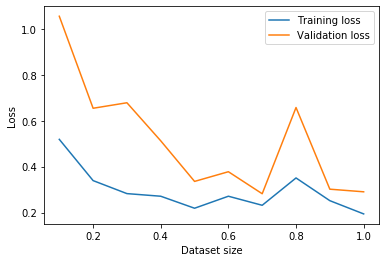

In [24]:
x = np.arange(0.1, 1.1, 0.1)
plt.plot(x, train_loss, label='Training loss')
plt.plot(x, val_loss, label='Validation loss')
plt.legend()
plt.xlabel("Dataset size")
plt.ylabel("Loss")
plt.show()

In [25]:
model.save('../Models/Small_MLP_Classification_GroupBy_FFill_MinMax.h5')